<img src="report_material/feup_logo_old.png" width="30%" align="center"/>

<h1 style="text-align:center">Neural Networks for the Prediction of Anuran Species (E3.)</h1>
<h3 style="text-align:center">Final Delivery</h3>
<br/><br/>
<p style="text-align:center">Artificial Intelligence (IART)</p>
<p style="text-align:center">3<sup>rd</sup> year in Master in Informatics and Computing Engineering</p>

### Authors

* Miguel Ramalho    - 201403027 - [m.ramalho@fe.up.pt](mailto:up201403027@fe.up.pt)
* Rostyslav Khoptiy - 201506219 - [up201506219@fe.up.pt](mailto:up201506219@fe.up.pt)

<!--spellchecking: https://stackoverflow.com/a/48710561/6196010 -->

<div style="text-align:right"><i>April 8<sup>th</sup>, 2018</i></div>
<br/><br/>

---

# Code

## Initialization

### Import modules

In [0]:
import pandas as pd
import tensorflow as tf
import numpy as np
import io # to pass data as StringIO object
import time # to set the random seed for train and test sampling
import matplotlib.pyplot as plt # to display plots
from sklearn.model_selection import KFold, StratifiedKFold # for cross-validation, needs scipy
np.seterr(divide='ignore', invalid='ignore'); # avoid unnecessary messages

### Initialize constants

In [0]:
DATASET_PATH = "dataset/frogs.csv" # the path to the dataset file
N_FEATURES   = 22 # the number of features in the dataset
LABEL_INDEX  = 24 # the index in the dataset where the label to predict is
BATCH_SIZE   = 100 # batch size for the train, evaluation and prediction
NUM_CLASSES  = 10 # last layer, num classifications
NUM_ITEMS    = 7195 #Num items in dataset
CROSS_VALIDATION_FUNCTION = StratifiedKFold # use KFold to ignore class representation
ACTIVATION_FUNCTION = tf.nn.sigmoid # default is tf.nn.relu

## Helper Functions

In this section we include functions that are directed at helping the visualisation of the project, the manipulation of data and the creation, training and evaluation of models. Here functions that start with an underscore (_) are purely 'private' helper functions and shouldn't be used or even considered for the evaluation of the report

### Chart Drawing and Visualization functions

In [0]:
from IPython.core.display import display_html, HTML
# function to print string into visual HTML
def html(s, html_tag=None):
    if html_tag:
        s = tag(html_tag, s)
    display_html(HTML(s))
def tag(tag, s):
    return "<%s>%s</%s>" % (tag, s, tag)

In [0]:
from IPython.display import display
# receives paddings and a list @layer_sizes with the number of nodes to draw
def _draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    # https://gist.github.com/craffel/2d727968c3aaebd10359
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(max(len(layer_sizes) - 1, 1))
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)
# helper function to draw a neural network
def drawNN(hidden_layers, figsize=(12, 12), name=None):
    #plt.ioff() #plt.ion()
    plt.tight_layout()
    fig = plt.figure(figsize=figsize);
    ax = fig.gca()
    ax.axis('off')
    _draw_neural_net(ax, .1, .9, .1, .9, [N_FEATURES] + hidden_layers + [NUM_CLASSES])
    display(fig);
    plt.close();

In [0]:
# create an abstract histogram
def _draw_label_distribution(label_column, title_text):
    label_count = pd.Series.value_counts(label_column, normalize=True, sort=False)
    label_count = label_count.sort_index()
    label_count.plot(kind='barh', title=title_text, stacked=True, fontsize=15, figsize=(8,8), color="darkblue" )

# create a histogram with the distribution of species
def draw_species_distribution_chart(df, title_text="Species Dataset Distribution"):
    species_column = df['Species']
    _draw_label_distribution(species_column, title_text)

### Creating Deep Neural Network Models 
 * `my_feature_columns`        - the features that the model should receive as input
 * `inner_layers_architecture` - a list of N hidden layers where N[i] is the number of nodes of the layer i

In [0]:
def create_DNN(my_feature_columns, inner_layers_architecture, save_folder_path=None, num_classes=NUM_CLASSES):
    # Build a DNN (Deep Neural Network) with 1 hidden layer with 10 nodes
    classifier = tf.estimator.DNNClassifier(
            feature_columns = my_feature_columns,
            hidden_units = inner_layers_architecture, # 1:-1 removes the first and last elements of the architecture
            n_classes = num_classes, # num nodes of final layer
            model_dir = save_folder_path, # value None means it will be saved in temp
            activation_fn = ACTIVATION_FUNCTION, # activation function to use
    )
    
    return classifier

### Training Models

In [0]:
SHUFFLE_PARAM = NUM_ITEMS * 10 #df.shape[0] * 10
# helper function to yield a part of the training data to be used by TF's classifier.train method
def _train_input_fn(features, labels):
    # Convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    
    # Shuffle, repeat, and batch the examples. The shuffle argument should be larger than the number of examples
    return dataset.shuffle(SHUFFLE_PARAM).repeat().batch(BATCH_SIZE)

In [0]:
# Train a model, given the train data and the number of steps
def train_model(classifier, train_x, numeric_train_y, num_steps=1000):
    classifier.train(input_fn=lambda:_train_input_fn(train_x, numeric_train_y), steps=num_steps)

### Evaluating Models

In [0]:
# helper function for the classifier.evaluate method
def _eval_input_fn(features, labels=None):
    inputs = features if labels is None else (features, labels)
    
    # Convert inputs to a tf.dataset object. Batch the examples.
    dataset = tf.data.Dataset.from_tensor_slices(inputs).batch(BATCH_SIZE)

    # Return the read end of the pipeline.
    return dataset.make_one_shot_iterator().get_next()

In [0]:
# Evaluate a model - returns a tuple (eval_results, global_step)
def evaluate_model(classifier, test_x, numeric_test_y):
    return classifier.evaluate(input_fn=lambda:_eval_input_fn(dict(test_x), numeric_test_y))

In [0]:
# predict from a trained model - returns a list of the predictions
def predict_model(classifier, predict_x):
    predictions = list(classifier.predict(input_fn=lambda:_eval_input_fn(dict(predict_x))))
    return [el["class_ids"][0] for el in predictions]

### Dataset Splitting

In [0]:
# converts a list of strings into a list of IDs (numerical values) used for the classifier
def _convert_labels_to_number(labels):
    unique_labels = list(set(labels)) # list of unique values
    return [unique_labels.index(l) for l in labels]

In [0]:
def _format_TF_data(train, test):
    # split dataframes into X (features) and y (classes) - use species as label
    train_x, train_y = train.iloc[:,:N_FEATURES], train.iloc[:,LABEL_INDEX:LABEL_INDEX+1]
    test_x, test_y = test.iloc[:,:N_FEATURES], test.iloc[:,LABEL_INDEX:LABEL_INDEX+1]
    
    # for the 10 species, get a numerical mapping of the text name of that species (needed for DNN)
    numeric_train_y = _convert_labels_to_number(train_y.iloc[:,0])
    numeric_test_y  = _convert_labels_to_number(test_y.iloc[:,0])
    
    return (train_x, numeric_train_y, test_x, numeric_test_y)

In [0]:
# Convert the features MFCCs_1 to MFCCs_22 into Tensorflow feature columns
def get_TF_feature_columns(df):
    data_df = df.iloc[:,:N_FEATURES]
    return [tf.feature_column.numeric_column(key=key) for key in list(data_df)]

#### Simple data splitting into Train and Test data

In [0]:
# returns a single iteration
def simple_data_split_generator(df, labels, train_fraction):
    train=df.sample(frac=train_fraction, random_state=int(time.time()))
    test=df.drop(train.index)
    yield _format_TF_data(train, test) # in a for loop gives one single loop

#### Cross Validation splitting into Train and Test data

In [0]:
def _split_data_by_indices(train_indices, test_indices):
    train = df.iloc[train_indices]
    test = df.iloc[test_indices]
    return _format_TF_data(train, test)

In [0]:
def _get_k_fold_CV_split_indices(df, labels, num_folds = 3):
    k_fold = CROSS_VALIDATION_FUNCTION(n_splits = num_folds, shuffle=True)
    return k_fold.split(df, labels)

In [0]:
def kFoldCV_tf_data_generator(df, labels, train_fraction):
    num_folds = int(1.0 / (1.0 - train_fraction))
    for train_indices, test_indices in _get_k_fold_CV_split_indices(df, labels, num_folds):
        yield(_split_data_by_indices(train_indices, test_indices))

### Hyper-Parameter Tuning
Given a dataset, the respective labels, a function to split the data and another to calculate the number of steps, this function iterates over all the defined architectures in **INNER_LAYERS** and over all the **NUM_STEPS** and over all the  **TRAIN_FRACTIONS** and does the following:
 * Split the data accordingly
 * Train the model
 * Evaluate the model
 * Report the results
 
This can be used for quick comparison of multiple combinations of architectures, number of steps and train fractions, essentially tuning **hyper-parameters**. More can hyper-parameters can be added if needed.

In [0]:
def run_model_iterations(df, labels, data_generator):
    evaluations = []
    for inner_architecture in INNER_LAYERS:
        #drawNN([N_FEATURES] + inner_architecture + [NUM_CLASSES])
        for num_steps in NUM_STEPS:
            for train_fraction in TRAIN_FRACTIONS:
                my_feature_columns = get_TF_feature_columns(df) # seems to need to generate one for each estimator
                classifier = create_DNN(my_feature_columns, inner_architecture)
                (train_x, numeric_train_y, test_x, numeric_test_y) = next(data_generator(df, labels, train_fraction))
                train_model(classifier, train_x, numeric_train_y, num_steps)
                eval_result = evaluate_model(classifier, test_x, numeric_test_y)
                predictions = predict_model(classifier, test_x)
                # evaluation results, only the results of the last evaluation and prediction done on estimator
                evaluations.append({"config": (inner_architecture, train_fraction, num_steps), "eval_result" : eval_result, "prediction": (np.array(predictions), np.array(numeric_test_y))})
    html("Model iterations complete", "h1")
    return evaluations # evaluations can have duplicate 'keys' if k-fold is used

## Evaluation Metrics Used

From the confusion matrix, we derive the number of **true positives** (`TP`), **false positives** (`FP`), **true negatives** (`TN`) and **false negatives** (`FN`).

<img src="report_material/images/multiclass_confusion.png" width="300px" />
<p style="text-align:center">Image of a confusion matrix for a multiclass classification problem</p>

$ precision = \frac{ TP}{TP + FP} $

$ recall  = \frac{TP}{TP + FN} $

$ accuracy = \frac{TP + TN}{TP + FP + FN + TN} $

$ F1-score = 2 \cdot \frac{precision\cdot recall}{precision+ recall} $

Further metrics such as **specificity**, **negative predictive value**, **false positive rate**, **false negative rate** and **false discovery rate** were also calculated, but were not considered when making model decisions

In [0]:
# calculate metrics based on confusion matrix -> precision, recall, f1, ...
def print_metrics(prediction, confusion_matrix):
    predicted, actual = prediction
    
    # get values from confusion matrix for each class
    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix) # false positives
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix) # false negatives
    TP = np.diag(confusion_matrix)  # true positives
    TN = confusion_matrix.sum() - (FP + FN + TP) # true negatives

    # calculate metrics
    TPR = TP/(TP+FN) # Recall, sensitivity, hit rate, or true positive rate
    TNR = TN/(TN+FP) # Specificity or true negative rate
    PPV = TP/(TP+FP) # Precision or positive predictive value
    NPV = TN/(TN+FN) # Negative predictive value
    FPR = FP/(FP+TN) # Fall out or false positive rate
    FNR = FN/(TP+FN) # False negative rate
    FDR = FP/(TP+FP) # False discovery rate
    F1  =  2 * ((PPV * TPR) / (PPV + TPR)) # f1-score
    ACC = (TP+TN)/(TP+FP+FN+TN) # accuracy
    
    #overall values in percentage
    metrics = tuple(map(lambda v: np.nanmean(v) * 100, [ACC, PPV, TPR, F1]))
    
    # create the table with the statistics
    header = tag("tr", "<th>Species</th><th>Accuracy</th> <th>Precision</th> <th>Recall</th> <th>F1-score</th>")
    body = ""
    footer = tag("tr", "<th>Average</th><th>%.2f%%</th> <th>%.2f%%</th> <th>%.2f%%</th> <th>%.2f%%</th>" % metrics)
    for i in range(len(TP)):
        body += tag("tr", "<td>%s</td><td>%.2f%%</td> <td>%.2f%%</td> <td>%.2f%%</td> <td>%.2f%%</td>" % (i, ACC[i] * 100, PPV[i] * 100, TPR[i] * 100, F1[i] * 100))
        
    table = "<table style='font-size:16px;margin-left:auto;margin-right:auto;'>%s%s%s</table>" % (header, body, footer)
    html(table)
    return metrics

In [0]:
# print a confusion matrix after a prediction
def get_confusion_matrix(prediction):
    predicted, actual = prediction
    con_mat = tf.confusion_matrix(actual, predicted, num_classes=NUM_CLASSES)
    with tf.Session():
        return tf.Tensor.eval(con_mat,feed_dict=None, session=None)

### Functions to display and describe the output of a model

In [0]:
def print_configs(configs):
    header = tag("tr", "<th>Hidden Layers</th><th>Training Fraction</th> <th>Number of Steps</th>")
    body = tag("tr", "<th>%s</th><th>%.0f%%</th><th>%s</th>" % (configs[0], configs[1] * 100, configs[2]))
    table = "<table style='font-size:16px;margin-left:auto;margin-right:auto;text-align=center'>%s%s</table>" % (header, body)
    html(table)

In [0]:
def display_model_results(evaluations):
    # show results, statistics
    print('Num Results: %d' % len(evaluations))
    chart_data = [] # data to create charts later
    for i, e in enumerate(evaluations):
        confusion_matrix = get_confusion_matrix(e["prediction"])
        html("<h2 style='text-align:center'>Iteration %d</h2>" % (i+1))
        
        print_configs(e["config"])
#         drawNN(e["config"][0], (7,7))
        
        html("Confusion Matrix:", "h4")
        html("<br/>")
        print(confusion_matrix)
        
        metrics = print_metrics(e["prediction"], confusion_matrix)
        
        html("<hr>")
        
        chart_data.append((e["config"], metrics)) # config, [ACC, PPV, TPR, F1]
    display_model_comparison(chart_data)

In [0]:
# compare different architectures, train ratios and number of steps
def display_model_comparison(chart_data):
#     print(chart_data)
#     plt.rcParams.update({'font.size': 16})
    for percentage in TRAIN_FRACTIONS:
        plt.figure(figsize=(20,10));
        for layers in INNER_LAYERS:
            x, y = [], []
            for data in chart_data:
                if data[0][0] == layers and data[0][1] == percentage:
                    x.append(data[0][2])
                    y.append(data[1][0])
            plt.plot(x, y, '-', label="%s layers" % layers)


        for steps in NUM_STEPS:
            y = []
            for data in chart_data:
                if data[0][2] == steps and data[0][1] == percentage:
                    y.append(data[1][0])
            plt.plot([steps] * len(y), y, 'x', label="%4d steps"%steps, markersize=16)

        plt.title('Evolution of Accuracy for a training fraction of %.f%%' % (percentage * 100))
        plt.legend(loc='best')
        plt.show()

# Main

### Loading Data

In [25]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
 
# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1FgfTiJIKbkHLg3xtajFrNTK4ef5m0VuT'
downloaded = drive.CreateFile({'id': file_id})
print('Downloaded content "{}"'.format(downloaded.GetContentString()[100:1000]))

Downloaded content "FCCs_12,MFCCs_13,MFCCs_14,MFCCs_15,MFCCs_16,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species,RecordID
1,0.152936298220384,-0.105585902844019,0.200721914808566,0.317201062343259,0.260763853131077,0.100944640810053,-0.150062604917616,-0.17112763198601,0.124676436148438,0.188654145822323,-0.0756217229244772,-0.156435925226375,0.0822451152835443,0.135752042383891,-0.0240166450287792,-0.108351107221198,-0.0776225214037558,-0.00956780151914234,0.0576839754007957,0.118680135068692,0.0140384456733697,Leptodactylidae,Adenomera,AdenomeraAndre,1
1,0.171534257314109,-0.0989747371205295,0.268425220827017,0.338671862995453,0.268353099863332,0.0608350871920449,-0.222474640379244,-0.207692670568256,0.170882873543032,0.27095827998887,-0.0950039445276873,-0.254341468381362,0.0227862345814336,0.163320101050209,0.0120222808645159,-0.0909740108032878,-0.0565095219192882,-0.035303356"


In [26]:
# from csv to pandas Dataframe
# df = pd.read_csv(DATASET_PATH)
df = pd.read_csv(io.StringIO(downloaded.GetContentString()))
df.columns = df.columns.str.replace(" ", "") # remove whitespace, needed for TF

print("Got %d examples from the .csv" % df.shape[0])
df.head()

Got 7195 examples from the .csv


,MFCCs_1,MFCCs_2,MFCCs_3,MFCCs_4,MFCCs_5,MFCCs_6,MFCCs_7,MFCCs_8,MFCCs_9,MFCCs_10,...,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species,RecordID
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,Leptodactylidae,Adenomera,AdenomeraAndre,1
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,Leptodactylidae,Adenomera,AdenomeraAndre,1
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,Leptodactylidae,Adenomera,AdenomeraAndre,1
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,Leptodactylidae,Adenomera,AdenomeraAndre,1
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,Leptodactylidae,Adenomera,AdenomeraAndre,1


In [0]:
# get a mapping of all the labels in the Dataset into its integer values (required for Stratified Cross Validation)
labels = _convert_labels_to_number(df.iloc[:,LABEL_INDEX:LABEL_INDEX+1].iloc[:,0])

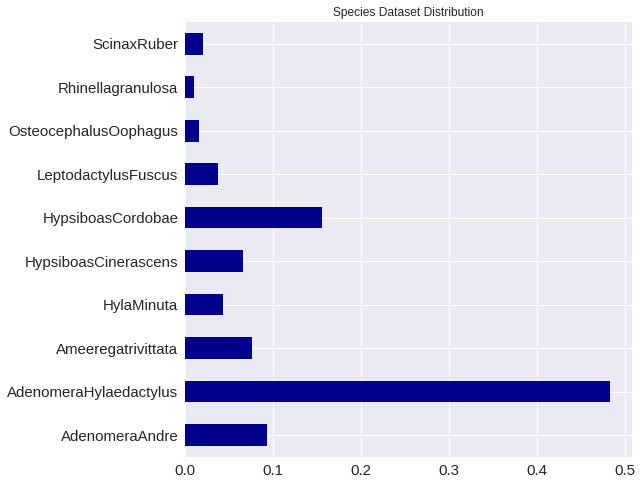

In [28]:
# draw dataset distribution
draw_species_distribution_chart(df)

### Running iterations

In [0]:
### Iterations

# modify here to set model configurations
INNER_LAYERS = [
    [10],
    [100],
    [10, 10],
    [100, 100],
    [10, 10, 10],
    [100, 100, 100],
    [100, 50, 25],
    [25, 50, 100]
]

TRAIN_FRACTIONS = [
    0.8,
    0.5,
]

NUM_STEPS = [
    100, 
    200,
    500,
    1000,
    1500,
    2000
]

### Initial approach to dataset splitting
Random split into train and test

**Warning:** Depending on the complexity of the architecture and the number of steps in the training, this operation may take some time

In [0]:
# this may take a while
#evaluations = run_model_iterations(df, labels, simple_data_split_generator)    

In [0]:
# simple data splitting results
#display_model_results(evaluations)

### Cross-Validation approach to dataset splitting
In **k-fold** cross-validation, the original sample is randomly partitioned into k equal size subsamples.

In **stratified k-fold** cross-validation, the folds are selected so that the mean response value is approximately equal in all the folds.

To use one or the other, update the global setting `CROSS_VALIDATION_FUNCTION` in the [Initialize constants](#Initialize-constants) section

**Warning:** Depending on the complexity of the architecture and the number of steps in the training, this operation may take some time

In [32]:
# k-fold cross validation
# this may take a while

# adjustment for k-fold: num_total_model_steps = num_steps * num_folds
kfcv_evaluations = run_model_iterations(df, labels, kFoldCV_tf_data_generator)    


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpqadilbp5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fdcdd1fb668>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpqadilbp5/model.ckpt.
INFO:tensorflow:loss = 230.92632, step = 0
INFO:tensorf

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmplfhlvwgv/model.ckpt.
INFO:tensorflow:loss = 224.41507, step = 0
INFO:tensorflow:global_step/sec: 146.863
INFO:tensorflow:loss = 98.368515, step = 100 (0.685 sec)
INFO:tensorflow:global_step/sec: 153.632
INFO:tensorflow:loss = 83.05354, step = 200 (0.648 sec)
INFO:tensorflow:global_step/sec: 157.427
INFO:tensorflow:loss = 65.96589, step = 300 (0.640 sec)
INFO:tensorflow:global_step/sec: 151.368
INFO:tensorflow:loss = 67.671, step = 400 (0.657 sec)
INFO:tensorflow:Saving checkpoints for 500 into /tmp/tmplfhlvwgv/model.ckpt.
INFO:tensorflow:Loss for final step: 75.66713.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-18-08:46:10
IN

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpluk8unbi/model.ckpt-1500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmplye55u9e', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fdcd6435668>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create Che

INFO:tensorflow:loss = 32.190826, step = 1300 (0.628 sec)
INFO:tensorflow:global_step/sec: 166.288
INFO:tensorflow:loss = 32.949123, step = 1400 (0.599 sec)
INFO:tensorflow:global_step/sec: 157.216
INFO:tensorflow:loss = 31.450216, step = 1500 (0.632 sec)
INFO:tensorflow:global_step/sec: 159.859
INFO:tensorflow:loss = 41.96254, step = 1600 (0.626 sec)
INFO:tensorflow:global_step/sec: 155.407
INFO:tensorflow:loss = 39.377804, step = 1700 (0.648 sec)
INFO:tensorflow:global_step/sec: 149.951
INFO:tensorflow:loss = 34.98765, step = 1800 (0.667 sec)
INFO:tensorflow:global_step/sec: 159.084
INFO:tensorflow:loss = 26.905695, step = 1900 (0.626 sec)
INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmpt0z9yde0/model.ckpt.
INFO:tensorflow:Loss for final step: 32.3601.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-18-08:47:24
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpt0z9yde

INFO:tensorflow:loss = 55.045753, step = 100 (0.646 sec)
INFO:tensorflow:global_step/sec: 158.773
INFO:tensorflow:loss = 44.304287, step = 200 (0.629 sec)
INFO:tensorflow:global_step/sec: 155.949
INFO:tensorflow:loss = 30.028917, step = 300 (0.640 sec)
INFO:tensorflow:global_step/sec: 174.216
INFO:tensorflow:loss = 37.053524, step = 400 (0.576 sec)
INFO:tensorflow:Saving checkpoints for 500 into /tmp/tmpiojfpc3h/model.ckpt.
INFO:tensorflow:Loss for final step: 34.95935.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-18-08:47:47
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpiojfpc3h/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-18-08:47:47
INFO:tensorflow:Saving dict for global step 500: accuracy = 0.9223839, average_loss = 0.3000547, global_step = 500, loss = 28.865261
INFO:te

INFO:tensorflow:global_step/sec: 166.992
INFO:tensorflow:loss = 29.444244, step = 400 (0.596 sec)
INFO:tensorflow:global_step/sec: 157.23
INFO:tensorflow:loss = 25.250647, step = 500 (0.635 sec)
INFO:tensorflow:global_step/sec: 156.741
INFO:tensorflow:loss = 28.999695, step = 600 (0.639 sec)
INFO:tensorflow:global_step/sec: 157.953
INFO:tensorflow:loss = 30.189806, step = 700 (0.630 sec)
INFO:tensorflow:global_step/sec: 173.042
INFO:tensorflow:loss = 22.483297, step = 800 (0.577 sec)
INFO:tensorflow:global_step/sec: 157.293
INFO:tensorflow:loss = 24.804548, step = 900 (0.638 sec)
INFO:tensorflow:global_step/sec: 155.318
INFO:tensorflow:loss = 30.461168, step = 1000 (0.648 sec)
INFO:tensorflow:global_step/sec: 158.197
INFO:tensorflow:loss = 15.037172, step = 1100 (0.629 sec)
INFO:tensorflow:global_step/sec: 176.799
INFO:tensorflow:loss = 19.97707, step = 1200 (0.565 sec)
INFO:tensorflow:global_step/sec: 156.068
INFO:tensorflow:loss = 16.45625, step = 1300 (0.640 sec)
INFO:tensorflow:glo

INFO:tensorflow:loss = 30.886652, step = 300 (0.612 sec)
INFO:tensorflow:global_step/sec: 157.313
INFO:tensorflow:loss = 27.08188, step = 400 (0.639 sec)
INFO:tensorflow:global_step/sec: 169.253
INFO:tensorflow:loss = 37.562668, step = 500 (0.588 sec)
INFO:tensorflow:global_step/sec: 159.119
INFO:tensorflow:loss = 29.186346, step = 600 (0.628 sec)
INFO:tensorflow:global_step/sec: 161.027
INFO:tensorflow:loss = 27.817034, step = 700 (0.621 sec)
INFO:tensorflow:global_step/sec: 161.282
INFO:tensorflow:loss = 33.225155, step = 800 (0.625 sec)
INFO:tensorflow:global_step/sec: 157.457
INFO:tensorflow:loss = 27.80662, step = 900 (0.630 sec)
INFO:tensorflow:global_step/sec: 171.382
INFO:tensorflow:loss = 22.718927, step = 1000 (0.583 sec)
INFO:tensorflow:global_step/sec: 154.429
INFO:tensorflow:loss = 12.440826, step = 1100 (0.648 sec)
INFO:tensorflow:global_step/sec: 161.822
INFO:tensorflow:loss = 23.579935, step = 1200 (0.621 sec)
INFO:tensorflow:global_step/sec: 161.146
INFO:tensorflow:los

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmp8up0h1qb/model.ckpt.
INFO:tensorflow:loss = 239.74348, step = 0
INFO:tensorflow:global_step/sec: 147.547
INFO:tensorflow:loss = 118.47916, step = 100 (0.684 sec)
INFO:tensorflow:global_step/sec: 151.755
INFO:tensorflow:loss = 123.486404, step = 200 (0.654 sec)
INFO:tensorflow:global_step/sec: 152.558
INFO:tensorflow:loss = 100.05412, step = 300 (0.661 sec)
INFO:tensorflow:global_step/sec: 167.363
INFO:tensorflow:loss = 84.88838, step = 400 (0.592 sec)
INFO:tensorflow:Saving checkpoints for 500 into /tmp/tmp8up0h1qb/model.ckpt.
INFO:tensorflow:Loss for final step: 78.89239.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-18-08:49:31
INFO:tensorflow:Graph was final

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpk1cqabai/model.ckpt.
INFO:tensorflow:loss = 228.62021, step = 0
INFO:tensorflow:global_step/sec: 146.611
INFO:tensorflow:loss = 113.23422, step = 100 (0.688 sec)
INFO:tensorflow:global_step/sec: 155.219
INFO:tensorflow:loss = 103.2041, step = 200 (0.644 sec)
INFO:tensorflow:global_step/sec: 155.897
INFO:tensorflow:loss = 95.96346, step = 300 (0.642 sec)
INFO:tensorflow:global_step/sec: 172.027
INFO:tensorflow:loss = 86.61831, step = 400 (0.578 sec)
INFO:tensorflow:global_step/sec: 156.5
INFO:tensorflow:loss = 67.55184, step = 500 (0.640 sec)
INFO:tensorflow:global_step/sec: 156.722
INFO:tensorflow:loss = 69.36168, step = 600 (0.638 sec)
INFO:tensorflow:global_step/sec: 158.368
INFO:tensorflow:loss = 57.352386, step = 700 (0.637 sec)
INFO:tensorflow:global_step/sec: 169.66

INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpet5yc55s/model.ckpt.
INFO:tensorflow:loss = 240.06738, step = 0
INFO:tensorflow:global_step/sec: 141.369
INFO:tensorflow:loss = 125.51801, step = 100 (0.712 sec)
INFO:tensorflow:global_step/sec: 151.945
INFO:tensorflow:loss = 96.60987, step = 200 (0.656 sec)
INFO:tensorflow:global_step/sec: 152.505
INFO:tensorflow:loss = 84.71176, step = 300 (0.655 sec)
INFO:tensorflow:global_step/sec: 151.003
INFO:tensorflow:loss = 74.80937, step = 400 (0.665 sec)
INFO:tensorflow:global_step/sec: 158.059
INFO:tensorflow:loss = 87.820885, step = 500 (0.632 sec)
INFO:tensorflow:global_step/sec: 146.242
INFO:tensorflow:loss = 68.27853, step = 600 (0.681 sec)
INFO:tensorflow:global_step/sec: 144.086
INFO:tensorflow:loss = 71.00406, step = 700 (0.698 sec)
INFO:tensorflow:global_step/sec: 150.233
INFO:tensorflow:loss = 62.92665, step = 800 (0.667 sec)
INFO:tensorflow:global_step/sec: 152.849
INFO:tensorflow:loss = 70.090775, step = 900 (0.655 sec)
INFO:t

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpei45nkkc', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fdcd69862b0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpei45nkkc/model.ckpt.
INFO:tensorflow:loss = 278.27905, step = 0
INFO:tensorf

INFO:tensorflow:Restoring parameters from /tmp/tmpwphettr5/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpkkg4s4f4', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fdcd6771b38>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 150.217
INFO:tensorflow:loss = 13.438906, step = 1900 (0.670 sec)
INFO:tensorflow:Saving checkpoints for 2000 into /tmp/tmp8if4qnc4/model.ckpt.
INFO:tensorflow:Loss for final step: 12.157001.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-18-08:52:26
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp8if4qnc4/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-18-08:52:26
INFO:tensorflow:Saving dict for global step 2000: accuracy = 0.954955, average_loss = 0.15761584, global_step = 2000, loss = 15.162644
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp8if4qnc4/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running l

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-18-08:52:56
INFO:tensorflow:Saving dict for global step 200: accuracy = 0.63686764, average_loss = 1.0443135, global_step = 200, loss = 100.46297
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmptv5t8szh/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp_hjvocb7', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fdcd6657be0>, '_task_type': 'worker', '_task_id': 0, '

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpki6gid1t/model.ckpt.
INFO:tensorflow:loss = 231.38503, step = 0
INFO:tensorflow:global_step/sec: 139.685
INFO:tensorflow:loss = 129.42984, step = 100 (0.720 sec)
INFO:tensorflow:global_step/sec: 153.058
INFO:tensorflow:loss = 99.66852, step = 200 (0.654 sec)
INFO:tensorflow:global_step/sec: 152.137
INFO:tensorflow:loss = 95.637985, step = 300 (0.654 sec)
INFO:tensorflow:global_step/sec: 148.235
INFO:tensorflow:loss = 77.99499, step = 400 (0.677 sec)
INFO:tensorflow:global_step/sec: 159.281
INFO:tensorflow:loss = 79.78115, step = 500 (0.626 sec)
INFO:tensorflow:global_step/sec: 142.652
INFO:tensorflow:loss = 67.395164, step = 600 (0.705 sec)
INFO:tensorflow:global_step/sec: 142.504
INFO:tensorflow:los

INFO:tensorflow:loss = 100.15677, step = 600 (0.684 sec)
INFO:tensorflow:global_step/sec: 148.962
INFO:tensorflow:loss = 101.82421, step = 700 (0.674 sec)
INFO:tensorflow:global_step/sec: 159.372
INFO:tensorflow:loss = 90.10849, step = 800 (0.626 sec)
INFO:tensorflow:global_step/sec: 140.291
INFO:tensorflow:loss = 78.78261, step = 900 (0.711 sec)
INFO:tensorflow:global_step/sec: 142.117
INFO:tensorflow:loss = 95.37883, step = 1000 (0.702 sec)
INFO:tensorflow:global_step/sec: 141.151
INFO:tensorflow:loss = 80.87721, step = 1100 (0.708 sec)
INFO:tensorflow:global_step/sec: 158.069
INFO:tensorflow:loss = 93.57935, step = 1200 (0.636 sec)
INFO:tensorflow:global_step/sec: 151.086
INFO:tensorflow:loss = 69.24884, step = 1300 (0.662 sec)
INFO:tensorflow:global_step/sec: 148.495
INFO:tensorflow:loss = 77.703094, step = 1400 (0.673 sec)
INFO:tensorflow:global_step/sec: 148.242
INFO:tensorflow:loss = 79.87484, step = 1500 (0.677 sec)
INFO:tensorflow:global_step/sec: 157.699
INFO:tensorflow:loss 

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpn6u3ofsf/model.ckpt.
INFO:tensorflow:loss = 242.74936, step = 0
INFO:tensorflow:global_step/sec: 140.894
INFO:tensorflow:loss = 101.95539, step = 100 (0.723 sec)
INFO:tensorflow:Saving checkpoints for 200 into /tmp/tmpn6u3ofsf/model.ckpt.
INFO:tensorflow:Loss for final step: 82.31974.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-18-08:54:48
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpn6u3ofsf/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-18-08:54:48
INFO:tensorflow:Saving dict for global step 200: accuracy = 0.74289674, average_loss = 0.76096195, global_step = 200, loss = 73.204544
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph w

INFO:tensorflow:Restoring parameters from /tmp/tmpxtqg9g6y/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpymy9ja63', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fdcbebabc18>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:

INFO:tensorflow:loss = 63.384754, step = 200 (0.672 sec)
INFO:tensorflow:global_step/sec: 143.024
INFO:tensorflow:loss = 76.774216, step = 300 (0.700 sec)
INFO:tensorflow:global_step/sec: 156.311
INFO:tensorflow:loss = 43.914246, step = 400 (0.637 sec)
INFO:tensorflow:global_step/sec: 143.062
INFO:tensorflow:loss = 41.54033, step = 500 (0.704 sec)
INFO:tensorflow:global_step/sec: 147.931
INFO:tensorflow:loss = 45.477043, step = 600 (0.673 sec)
INFO:tensorflow:global_step/sec: 151.327
INFO:tensorflow:loss = 29.1017, step = 700 (0.658 sec)
INFO:tensorflow:global_step/sec: 165.436
INFO:tensorflow:loss = 36.205494, step = 800 (0.605 sec)
INFO:tensorflow:global_step/sec: 152.893
INFO:tensorflow:loss = 15.926177, step = 900 (0.657 sec)
INFO:tensorflow:global_step/sec: 149.684
INFO:tensorflow:loss = 17.924702, step = 1000 (0.665 sec)
INFO:tensorflow:global_step/sec: 152.572
INFO:tensorflow:loss = 32.086872, step = 1100 (0.660 sec)
INFO:tensorflow:global_step/sec: 161.845
INFO:tensorflow:loss 

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpe2kz3d8m/model.ckpt.
INFO:tensorflow:loss = 233.15695, step = 0
INFO:tensorflow:global_step/sec: 136.371
INFO:tensorflow:loss = 93.20641, step = 100 (0.738 sec)
INFO:tensorflow:Saving checkpoints for 200 into /tmp/tmpe2kz3d8m/model.ckpt.
INFO:tensorflow:Loss for final step: 87.40945.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-18-08:56:41
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpe2kz3d8m/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-18-08:56:41
INFO:tensorflow:Saving dict for global step 200: accuracy = 0.78655577, a

INFO:tensorflow:Restoring parameters from /tmp/tmpcxh7lcvh/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-18-08:57:10
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.8884269, average_loss = 0.35626894, global_step = 1000, loss = 34.27307
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpcxh7lcvh/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpl2n7s_rh', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <t

INFO:tensorflow:Saving dict for global step 1500: accuracy = 0.9252362, average_loss = 0.2789192, global_step = 1500, loss = 27.876425
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp1m5yls1d/model.ckpt-1500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmprlhmf4l3', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fdcbed09048>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_repli

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpnqa3o2mn', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fdcd6279978>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpj01p0hx3/model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmphthjnunm', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fdcd69e6198>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Run

INFO:tensorflow:loss = 60.30714, step = 500 (0.668 sec)
INFO:tensorflow:global_step/sec: 146.278
INFO:tensorflow:loss = 53.599552, step = 600 (0.682 sec)
INFO:tensorflow:global_step/sec: 147.344
INFO:tensorflow:loss = 34.84589, step = 700 (0.678 sec)
INFO:tensorflow:global_step/sec: 151.619
INFO:tensorflow:loss = 38.77546, step = 800 (0.660 sec)
INFO:tensorflow:global_step/sec: 148.111
INFO:tensorflow:loss = 33.364326, step = 900 (0.680 sec)
INFO:tensorflow:global_step/sec: 149.167
INFO:tensorflow:loss = 36.49971, step = 1000 (0.666 sec)
INFO:tensorflow:global_step/sec: 152.284
INFO:tensorflow:loss = 40.335064, step = 1100 (0.659 sec)
INFO:tensorflow:global_step/sec: 149.397
INFO:tensorflow:loss = 27.697142, step = 1200 (0.666 sec)
INFO:tensorflow:global_step/sec: 149.672
INFO:tensorflow:loss = 27.114452, step = 1300 (0.674 sec)
INFO:tensorflow:global_step/sec: 154.522
INFO:tensorflow:loss = 38.120174, step = 1400 (0.644 sec)
INFO:tensorflow:Saving checkpoints for 1500 into /tmp/tmp_oz

Model iterations complete

Num Results: 96


Iteration 1

Hidden Layers,Training Fraction,Number of Steps
[10],80%,100


Confusion Matrix:

[[ 57  78   0   0   0   0   0   0   0   0]
 [  0 213   0   0   0   0  12   0   0   0]
 [  0 109   0   0   0   0   0   0   0   0]
 [  0  93   0   0   0   0   2   0   0   0]
 [  0  23   0   0   0   0   0   0   0   0]
 [  0  54   0   0   0   0   0   0   0   0]
 [  0   2   0   0   0   0 694   0   0   0]
 [  4  24   0   0   0   0  34   0   0   0]
 [  0  14   0   0   0   0   0   0   0   0]
 [  0  15   0   0   0   0  15   0   0   0]]


Species,Accuracy,Precision,Recall,F1-score
0,94.32%,93.44%,42.22%,58.16%
1,70.62%,34.08%,94.67%,50.12%
2,92.45%,nan%,0.00%,nan%
3,93.42%,nan%,0.00%,nan%
4,98.41%,nan%,0.00%,nan%
5,96.26%,nan%,0.00%,nan%
6,95.50%,91.68%,99.71%,95.53%
7,95.70%,nan%,0.00%,nan%
8,99.03%,nan%,0.00%,nan%
9,97.92%,nan%,0.00%,nan%


Iteration 2

Hidden Layers,Training Fraction,Number of Steps
[10],50%,100


Confusion Matrix:

[[ 312    7    0    0    0    0   17    0    0    0]
 [   0  184    0    0    0    0  377    0    0    0]
 [ 226    5    0    0    0    0   40    0    0    0]
 [   1   83    0    8    0    0  144    0    0    0]
 [   0   50    0    1    0    0    6    0    0    0]
 [   5  117    0    0    0    0   13    0    0    0]
 [   0    4    0    0    0    0 1735    0    0    0]
 [  48    6    0    0    0    0  101    0    0    0]
 [   1   31    0    0    0    0    2    0    0    0]
 [   1    9    0    0    0    0   64    0    0    0]]


Species,Accuracy,Precision,Recall,F1-score
0,91.50%,52.53%,92.86%,67.10%
1,80.85%,37.10%,32.80%,34.82%
2,92.47%,nan%,0.00%,nan%
3,93.64%,88.89%,3.39%,6.53%
4,98.42%,nan%,0.00%,nan%
5,96.25%,nan%,0.00%,nan%
6,78.65%,69.43%,99.77%,81.88%
7,95.69%,nan%,0.00%,nan%
8,99.06%,nan%,0.00%,nan%
9,97.94%,nan%,0.00%,nan%


Iteration 3

Hidden Layers,Training Fraction,Number of Steps
[10],80%,200


Confusion Matrix:

[[121  11   3   0   0   0   0   0   0   0]
 [  1 215   0   0   0   0   9   0   0   0]
 [ 28  18  62   0   0   0   1   0   0   0]
 [  0  18   0  74   0   0   3   0   0   0]
 [  0  20   0   3   0   0   0   0   0   0]
 [  1  53   0   0   0   0   0   0   0   0]
 [  0   4   0   1   0   0 691   0   0   0]
 [ 10  15   8   0   0   0  29   0   0   0]
 [  2  12   0   0   0   0   0   0   0   0]
 [  1  13   0   0   0   0  16   0   0   0]]


Species,Accuracy,Precision,Recall,F1-score
0,96.05%,73.78%,89.63%,80.94%
1,87.94%,56.73%,95.56%,71.19%
2,95.98%,84.93%,56.88%,68.13%
3,98.27%,94.87%,77.89%,85.55%
4,98.41%,nan%,0.00%,nan%
5,96.26%,nan%,0.00%,nan%
6,95.63%,92.26%,99.28%,95.64%
7,95.70%,nan%,0.00%,nan%
8,99.03%,nan%,0.00%,nan%
9,97.92%,nan%,0.00%,nan%


Iteration 4

Hidden Layers,Training Fraction,Number of Steps
[10],50%,200


Confusion Matrix:

[[ 298   38    0    0    0    0    0    0    0    0]
 [   0  548    0    0    0    0   13    0    0    0]
 [ 111  160    0    0    0    0    0    0    0    0]
 [  23  185    0   28    0    0    0    0    0    0]
 [   6   49    0    2    0    0    0    0    0    0]
 [   2  133    0    0    0    0    0    0    0    0]
 [   0    1    0    0    0    0 1738    0    0    0]
 [  47   39    0    0    0    0   69    0    0    0]
 [   4   30    0    0    0    0    0    0    0    0]
 [   1   47    0    0    0    0   26    0    0    0]]


Species,Accuracy,Precision,Recall,F1-score
0,93.55%,60.57%,88.69%,71.98%
1,80.68%,44.55%,97.68%,61.19%
2,92.47%,nan%,0.00%,nan%
3,94.16%,93.33%,11.86%,21.05%
4,98.42%,nan%,0.00%,nan%
5,96.25%,nan%,0.00%,nan%
6,96.97%,94.15%,99.94%,96.96%
7,95.69%,nan%,0.00%,nan%
8,99.06%,nan%,0.00%,nan%
9,97.94%,nan%,0.00%,nan%


Iteration 5

Hidden Layers,Training Fraction,Number of Steps
[10],80%,500


Confusion Matrix:

[[127   4   4   0   0   0   0   0   0   0]
 [  1 222   0   0   0   0   2   0   0   0]
 [ 35   3  71   0   0   0   0   0   0   0]
 [  3   1   0  91   0   0   0   0   0   0]
 [  1  16   0   6   0   0   0   0   0   0]
 [  4  48   1   0   0   0   0   1   0   0]
 [  1   1   0   1   0   0 693   0   0   0]
 [ 11   1  23   0   0   0  20   7   0   0]
 [  9   4   0   1   0   0   0   0   0   0]
 [  0   8   4   3   0   0  14   1   0   0]]


Species,Accuracy,Precision,Recall,F1-score
0,94.94%,66.15%,94.07%,77.68%
1,93.83%,72.08%,98.67%,83.30%
2,95.15%,68.93%,65.14%,66.98%
3,98.96%,89.22%,95.79%,92.39%
4,98.41%,nan%,0.00%,nan%
5,96.26%,nan%,0.00%,nan%
6,97.30%,95.06%,99.57%,97.26%
7,96.05%,77.78%,11.29%,19.72%
8,99.03%,nan%,0.00%,nan%
9,97.92%,nan%,0.00%,nan%


Iteration 6

Hidden Layers,Training Fraction,Number of Steps
[10],50%,500


Confusion Matrix:

[[ 320    2   12    2    0    0    0    0    0    0]
 [   1  551    0    3    0    0    6    0    0    0]
 [ 108   23  140    0    0    0    0    0    0    0]
 [  13   12    0  211    0    0    0    0    0    0]
 [   2   40    0   15    0    0    0    0    0    0]
 [   6  121    0    0    0    0    1    7    0    0]
 [   0    0    1    2    0    0 1736    0    0    0]
 [  24    7   31    0    0    0   41   52    0    0]
 [  25    9    0    0    0    0    0    0    0    0]
 [   0   40    4    4    0    0   26    0    0    0]]


Species,Accuracy,Precision,Recall,F1-score
0,94.58%,64.13%,95.24%,76.65%
1,92.66%,68.45%,98.22%,80.67%
2,95.03%,74.47%,51.66%,61.00%
3,98.58%,89.03%,89.41%,89.22%
4,98.42%,nan%,0.00%,nan%
5,96.25%,nan%,0.00%,nan%
6,97.86%,95.91%,99.83%,97.83%
7,96.94%,88.14%,33.55%,48.60%
8,99.06%,nan%,0.00%,nan%
9,97.94%,nan%,0.00%,nan%


Iteration 7

Hidden Layers,Training Fraction,Number of Steps
[10],80%,1000


Confusion Matrix:

[[120   0  15   0   0   0   0   0   0   0]
 [  0 222   0   2   0   0   1   0   0   0]
 [  4   1 104   0   0   0   0   0   0   0]
 [  1   3   0  91   0   0   0   0   0   0]
 [  4  11   0   8   0   0   0   0   0   0]
 [  0  54   0   0   0   0   0   0   0   0]
 [  0   1   0   1   0   0 694   0   0   0]
 [  7   0  17   0   0   0  17  21   0   0]
 [ 10   4   0   0   0   0   0   0   0   0]
 [  5   6   6   2   0   0   7   4   0   0]]


Species,Accuracy,Precision,Recall,F1-score
0,96.81%,79.47%,88.89%,83.92%
1,94.25%,73.51%,98.67%,84.25%
2,97.02%,73.24%,95.41%,82.87%
3,98.82%,87.50%,95.79%,91.46%
4,98.41%,nan%,0.00%,nan%
5,96.26%,nan%,0.00%,nan%
6,98.13%,96.52%,99.71%,98.09%
7,96.88%,84.00%,33.87%,48.28%
8,99.03%,nan%,0.00%,nan%
9,97.92%,nan%,0.00%,nan%


Iteration 8

Hidden Layers,Training Fraction,Number of Steps
[10],50%,1000


Confusion Matrix:

[[ 316    4   14    2    0    0    0    0    0    0]
 [   0  543    0    7    0    4    7    0    0    0]
 [   7    1  262    0    0    0    0    1    0    0]
 [   5    4    0  224    0    3    0    0    0    0]
 [   1   41    0   14    0    1    0    0    0    0]
 [   4   21    0    0    0  108    1    1    0    0]
 [   0    4    0    0    0    0 1735    0    0    0]
 [  28   11   37    0    0    0   24   55    0    0]
 [   2   27    2    0    0    3    0    0    0    0]
 [   1   26    7    5    0    0   29    6    0    0]]


Species,Accuracy,Precision,Recall,F1-score
0,98.11%,86.81%,94.05%,90.29%
1,95.64%,79.62%,96.79%,87.37%
2,98.08%,81.37%,96.68%,88.36%
3,98.89%,88.89%,94.92%,91.80%
4,98.42%,nan%,0.00%,nan%
5,98.94%,90.76%,80.00%,85.04%
6,98.19%,96.60%,99.77%,98.16%
7,97.00%,87.30%,35.48%,50.46%
8,99.06%,nan%,0.00%,nan%
9,97.94%,nan%,0.00%,nan%


Iteration 9

Hidden Layers,Training Fraction,Number of Steps
[10],80%,1500


Confusion Matrix:

[[131   1   3   0   0   0   0   0   0   0]
 [  0 225   0   0   0   0   0   0   0   0]
 [  1   1 107   0   0   0   0   0   0   0]
 [  3   5   0  87   0   0   0   0   0   0]
 [  1  17   0   5   0   0   0   0   0   0]
 [  0   9   0   0   0  45   0   0   0   0]
 [  0   0   0   0   0   0 694   2   0   0]
 [  8   6  14   0   0   0  10  24   0   0]
 [  1   4   8   0   0   1   0   0   0   0]
 [  0  13   0   2   0   0   9   3   0   3]]


Species,Accuracy,Precision,Recall,F1-score
0,98.75%,90.34%,97.04%,93.57%
1,96.12%,80.07%,100.00%,88.93%
2,98.13%,81.06%,98.17%,88.80%
3,98.96%,92.55%,91.58%,92.06%
4,98.41%,nan%,0.00%,nan%
5,99.31%,97.83%,83.33%,90.00%
6,98.54%,97.34%,99.71%,98.51%
7,97.02%,82.76%,38.71%,52.75%
8,99.03%,nan%,0.00%,nan%
9,98.13%,100.00%,10.00%,18.18%


Iteration 10

Hidden Layers,Training Fraction,Number of Steps
[10],50%,1500


Confusion Matrix:

[[ 309    6   19    1    0    1    0    0    0    0]
 [   0  552    0    4    0    2    3    0    0    0]
 [  13    0  257    0    0    0    0    1    0    0]
 [   2    1    0  228    0    5    0    0    0    0]
 [   3   35    0   16    0    3    0    0    0    0]
 [   2   20    0    0    0  112    1    0    0    0]
 [   0    1    0    0    0    0 1738    0    0    0]
 [  26    4   44    0    0    0   31   50    0    0]
 [  10    3   15    2    0    4    0    0    0    0]
 [   1    8    0    8    0    0   33   20    0    4]]


Species,Accuracy,Precision,Recall,F1-score
0,97.67%,84.43%,91.96%,88.03%
1,97.58%,87.62%,98.40%,92.70%
2,97.44%,76.72%,94.83%,84.82%
3,98.92%,88.03%,96.61%,92.12%
4,98.42%,nan%,0.00%,nan%
5,98.94%,88.19%,82.96%,85.50%
6,98.08%,96.23%,99.94%,98.05%
7,96.50%,70.42%,32.26%,44.25%
8,99.06%,nan%,0.00%,nan%
9,98.05%,100.00%,5.41%,10.26%


Iteration 11

Hidden Layers,Training Fraction,Number of Steps
[10],80%,2000


Confusion Matrix:

[[130   2   3   0   0   0   0   0   0   0]
 [  1 219   0   1   0   1   3   0   0   0]
 [  4   0 105   0   0   0   0   0   0   0]
 [  2   4   0  88   0   1   0   0   0   0]
 [  7  10   0   6   0   0   0   0   0   0]
 [  1   1   0   0   0  50   0   2   0   0]
 [  0   1   1   1   0   0 692   1   0   0]
 [ 19   1  13   0   0   0   8  21   0   0]
 [ 11   1   1   0   0   0   0   0   0   1]
 [  2   3   2   3   0   0   1   6   0  13]]


Species,Accuracy,Precision,Recall,F1-score
0,96.40%,73.45%,96.30%,83.33%
1,97.99%,90.50%,97.33%,93.79%
2,98.34%,84.00%,96.33%,89.74%
3,98.75%,88.89%,92.63%,90.72%
4,98.41%,nan%,0.00%,nan%
5,99.58%,96.15%,92.59%,94.34%
6,98.89%,98.30%,99.43%,98.86%
7,96.53%,70.00%,33.87%,45.65%
8,99.03%,nan%,0.00%,nan%
9,98.75%,92.86%,43.33%,59.09%


Iteration 12

Hidden Layers,Training Fraction,Number of Steps
[10],50%,2000


Confusion Matrix:

[[ 316    3   16    1    0    0    0    0    0    0]
 [   0  551    0    2    0    7    1    0    0    0]
 [  16    1  252    0    0    0    0    2    0    0]
 [   1    3    0  228    0    4    0    0    0    0]
 [   1   39    0   16    0    1    0    0    0    0]
 [   0    7    0    2    0  125    0    1    0    0]
 [   0    2    1    1    0    0 1734    1    0    0]
 [  22    3   42    0    0    0   26   61    0    1]
 [  12    6   14    0    0    2    0    0    0    0]
 [   2   12    0   10    0    0   17   20    0   13]]


Species,Accuracy,Precision,Recall,F1-score
0,97.94%,85.41%,94.05%,89.52%
1,97.61%,87.88%,98.22%,92.76%
2,97.44%,77.54%,92.99%,84.56%
3,98.89%,87.69%,96.61%,91.94%
4,98.42%,nan%,0.00%,nan%
5,99.33%,89.93%,92.59%,91.24%
6,98.64%,97.53%,99.71%,98.61%
7,96.72%,71.76%,39.35%,50.83%
8,99.06%,nan%,0.00%,nan%
9,98.28%,92.86%,17.57%,29.55%


Iteration 13

Hidden Layers,Training Fraction,Number of Steps
[100],80%,100


Confusion Matrix:

[[128   3   3   1   0   0   0   0   0   0]
 [  1 218   0   2   0   0   4   0   0   0]
 [ 33   8  68   0   0   0   0   0   0   0]
 [  4   3   0  88   0   0   0   0   0   0]
 [  1  17   0   5   0   0   0   0   0   0]
 [  1  51   1   0   0   0   1   0   0   0]
 [  0   1   1   1   0   0 693   0   0   0]
 [ 22  18   4   0   0   0  18   0   0   0]
 [  0  13   0   1   0   0   0   0   0   0]
 [  0  16   0   1   0   0  13   0   0   0]]


Species,Accuracy,Precision,Recall,F1-score
0,95.22%,67.37%,94.81%,78.77%
1,90.51%,62.64%,96.89%,76.09%
2,96.53%,88.31%,62.39%,73.12%
3,98.75%,88.89%,92.63%,90.72%
4,98.41%,nan%,0.00%,nan%
5,96.26%,nan%,0.00%,nan%
6,97.30%,95.06%,99.57%,97.26%
7,95.70%,nan%,0.00%,nan%
8,99.03%,nan%,0.00%,nan%
9,97.92%,nan%,0.00%,nan%


Iteration 14

Hidden Layers,Training Fraction,Number of Steps
[100],50%,100


Confusion Matrix:

[[ 320    6    9    1    0    0    0    0    0    0]
 [   1  541    0    3    0    0   16    0    0    0]
 [ 125   34  112    0    0    0    0    0    0    0]
 [   9    3    0  224    0    0    0    0    0    0]
 [   1   44    0   12    0    0    0    0    0    0]
 [   6   92    1    0    0   31    3    2    0    0]
 [   1    0    0    1    0    0 1737    0    0    0]
 [  33   22   28    0    0    0   57   15    0    0]
 [   6   28    0    0    0    0    0    0    0    0]
 [   1   40    0    2    0    0   31    0    0    0]]


Species,Accuracy,Precision,Recall,F1-score
0,94.47%,63.62%,95.24%,76.28%
1,91.97%,66.79%,96.43%,78.92%
2,94.52%,74.67%,41.33%,53.21%
3,99.14%,92.18%,94.92%,93.53%
4,98.42%,nan%,0.00%,nan%
5,97.11%,100.00%,22.96%,37.35%
6,96.97%,94.20%,99.88%,96.96%
7,96.05%,88.24%,9.68%,17.44%
8,99.06%,nan%,0.00%,nan%
9,97.94%,nan%,0.00%,nan%


Iteration 15

Hidden Layers,Training Fraction,Number of Steps
[100],80%,200


Confusion Matrix:

[[114   1  19   1   0   0   0   0   0   0]
 [  0 217   0   6   0   0   2   0   0   0]
 [  1   2 106   0   0   0   0   0   0   0]
 [  3   3   0  89   0   0   0   0   0   0]
 [  0  20   0   3   0   0   0   0   0   0]
 [  5  36   0   0   0  12   0   1   0   0]
 [  0   2   0   0   0   0 694   0   0   0]
 [  6   4  15   0   0   0  16  21   0   0]
 [  2  11   0   1   0   0   0   0   0   0]
 [  1  11   2   2   0   0  14   0   0   0]]


Species,Accuracy,Precision,Recall,F1-score
0,97.30%,86.36%,84.44%,85.39%
1,93.21%,70.68%,96.44%,81.58%
2,97.30%,74.65%,97.25%,84.46%
3,98.68%,87.25%,93.68%,90.36%
4,98.41%,nan%,0.00%,nan%
5,97.09%,100.00%,22.22%,36.36%
6,97.64%,95.59%,99.71%,97.61%
7,97.09%,95.45%,33.87%,50.00%
8,99.03%,nan%,0.00%,nan%
9,97.92%,nan%,0.00%,nan%


Iteration 16

Hidden Layers,Training Fraction,Number of Steps
[100],50%,200


Confusion Matrix:

[[ 305    3   26    2    0    0    0    0    0    0]
 [   1  538    0    9    0    6    7    0    0    0]
 [   7    3  261    0    0    0    0    0    0    0]
 [   1    6    0  221    0    8    0    0    0    0]
 [   1   39    0   15    0    2    0    0    0    0]
 [   4   25    2    0    0  103    0    1    0    0]
 [   0    1    2    0    0    0 1736    0    0    0]
 [  23    4   61    0    0    0   31   36    0    0]
 [   4   24    1    2    0    3    0    0    0    0]
 [   1   32    9    5    0    0   27    0    0    0]]


Species,Accuracy,Precision,Recall,F1-score
0,97.97%,87.90%,90.77%,89.31%
1,95.55%,79.70%,95.90%,87.06%
2,96.91%,72.10%,96.31%,82.46%
3,98.67%,87.01%,93.64%,90.20%
4,98.42%,nan%,0.00%,nan%
5,98.58%,84.43%,76.30%,80.16%
6,98.11%,96.39%,99.83%,98.08%
7,96.66%,97.30%,23.23%,37.50%
8,99.06%,nan%,0.00%,nan%
9,97.94%,nan%,0.00%,nan%


Iteration 17

Hidden Layers,Training Fraction,Number of Steps
[100],80%,500


Confusion Matrix:

[[127   2   4   1   0   0   0   1   0   0]
 [  0 224   0   0   0   1   0   0   0   0]
 [  2   0 104   0   0   0   0   3   0   0]
 [  3   3   0  87   1   1   0   0   0   0]
 [  0  16   0   5   1   1   0   0   0   0]
 [  3   6   0   0   0  44   0   1   0   0]
 [  0   0   2   0   0   0 692   2   0   0]
 [ 11   1  12   0   0   0   7  31   0   0]
 [  7   1   4   1   0   1   0   0   0   0]
 [  0   2   5   0   1   0   0   1   0  21]]


Species,Accuracy,Precision,Recall,F1-score
0,97.64%,83.01%,94.07%,88.19%
1,97.78%,87.84%,99.56%,93.33%
2,97.78%,79.39%,95.41%,86.67%
3,98.96%,92.55%,91.58%,92.06%
4,98.34%,33.33%,4.35%,7.69%
5,99.03%,91.67%,81.48%,86.27%
6,99.24%,99.00%,99.43%,99.21%
7,97.30%,79.49%,50.00%,61.39%
8,99.03%,nan%,0.00%,nan%
9,99.38%,100.00%,70.00%,82.35%


Iteration 18

Hidden Layers,Training Fraction,Number of Steps
[100],50%,500


Confusion Matrix:

[[ 318    2   12    3    1    0    0    0    0    0]
 [   0  545    0    3    0   11    2    0    0    0]
 [   7    1  256    0    0    0    0    7    0    0]
 [   2    2    0  225    5    2    0    0    0    0]
 [   1   39    0   13    3    1    0    0    0    0]
 [   2    5    0    3    0  124    0    1    0    0]
 [   0    0    3    1    0    0 1734    1    0    0]
 [  26    3   26    0    0    0   22   78    0    0]
 [  18    8    3    1    0    3    0    0    0    1]
 [   1   16    1    5    0    0    1    6    0   44]]


Species,Accuracy,Precision,Recall,F1-score
0,97.92%,84.80%,94.64%,89.45%
1,97.44%,87.76%,97.15%,92.22%
2,98.33%,85.05%,94.46%,89.51%
3,98.89%,88.58%,95.34%,91.84%
4,98.33%,33.33%,5.26%,9.09%
5,99.22%,87.94%,91.85%,89.86%
6,99.17%,98.58%,99.71%,99.14%
7,97.44%,83.87%,50.32%,62.90%
8,99.06%,nan%,0.00%,nan%
9,99.14%,97.78%,59.46%,73.95%


Iteration 19

Hidden Layers,Training Fraction,Number of Steps
[100],80%,1000


Confusion Matrix:

[[130   0   4   0   1   0   0   0   0   0]
 [  0 222   0   2   0   1   0   0   0   0]
 [  3   0 100   0   0   0   0   5   0   1]
 [  1   1   0  91   2   0   0   0   0   0]
 [  0   4   0   6  12   1   0   0   0   0]
 [  3   2   0   1   0  46   0   2   0   0]
 [  0   0   0   0   0   0 696   0   0   0]
 [  6   1   4   0   0   0   6  45   0   0]
 [  3   1   0   0   1   0   0   0   9   0]
 [  0   0   0   2   1   0   0   0   0  27]]


Species,Accuracy,Precision,Recall,F1-score
0,98.54%,89.04%,96.30%,92.53%
1,99.17%,96.10%,98.67%,97.37%
2,98.82%,92.59%,91.74%,92.17%
3,98.96%,89.22%,95.79%,92.39%
4,98.89%,70.59%,52.17%,60.00%
5,99.31%,95.83%,85.19%,90.20%
6,99.58%,99.15%,100.00%,99.57%
7,98.34%,86.54%,72.58%,78.95%
8,99.65%,100.00%,64.29%,78.26%
9,99.72%,96.43%,90.00%,93.10%


Iteration 20

Hidden Layers,Training Fraction,Number of Steps
[100],50%,1000


Confusion Matrix:

[[ 310    1   19    5    1    0    0    0    0    0]
 [   0  550    0    3    1    6    0    1    0    0]
 [   2    0  260    0    0    0    0    7    1    1]
 [   1    1    0  223    8    3    0    0    0    0]
 [   1   13    0   13   30    0    0    0    0    0]
 [   4    5    0    1    0  122    0    2    1    0]
 [   0    3    5    1    0    0 1728    2    0    0]
 [  25    0   14    0    0    0   24   88    0    4]
 [   1    0    1    0    1    0    0    0   31    0]
 [   0    4    0    4    1    0    0    1    2   62]]


Species,Accuracy,Precision,Recall,F1-score
0,98.33%,90.12%,92.26%,91.18%
1,98.94%,95.32%,98.04%,96.66%
2,98.61%,86.96%,95.94%,91.23%
3,98.89%,89.20%,94.49%,91.77%
4,98.92%,71.43%,52.63%,60.61%
5,99.39%,93.13%,90.37%,91.73%
6,99.03%,98.63%,99.37%,99.00%
7,97.78%,87.13%,56.77%,68.75%
8,99.81%,88.57%,91.18%,89.86%
9,99.53%,92.54%,83.78%,87.94%


Iteration 21

Hidden Layers,Training Fraction,Number of Steps
[100],80%,1500


Confusion Matrix:

[[124   0   8   1   1   0   0   1   0   0]
 [  0 222   0   1   0   2   0   0   0   0]
 [  0   0 104   0   0   0   0   5   0   0]
 [  0   1   0  89   3   2   0   0   0   0]
 [  0   3   0   5  15   0   0   0   0   0]
 [  0   2   0   1   0  51   0   0   0   0]
 [  0   0   0   0   0   0 696   0   0   0]
 [  6   1   5   0   0   0  10  40   0   0]
 [  2   0   1   0   1   1   0   0   9   0]
 [  0   2   0   0   1   0   0   2   0  25]]


Species,Accuracy,Precision,Recall,F1-score
0,98.68%,93.94%,91.85%,92.88%
1,99.17%,96.10%,98.67%,97.37%
2,98.68%,88.14%,95.41%,91.63%
3,99.03%,91.75%,93.68%,92.71%
4,99.03%,71.43%,65.22%,68.18%
5,99.45%,91.07%,94.44%,92.73%
6,99.31%,98.58%,100.00%,99.29%
7,97.92%,83.33%,64.52%,72.73%
8,99.65%,100.00%,64.29%,78.26%
9,99.65%,100.00%,83.33%,90.91%


Iteration 22

Hidden Layers,Training Fraction,Number of Steps
[100],50%,1500


Confusion Matrix:

[[ 314    2   12    2    4    0    0    2    0    0]
 [   0  551    0    1    1    6    1    1    0    0]
 [   1    0  260    0    0    0    0    7    1    2]
 [   2    3    0  225    6    0    0    0    0    0]
 [   0    9    0   14   33    0    0    0    1    0]
 [   4    7    0    2    0  116    0    4    2    0]
 [   0    1    1    1    0    0 1734    1    0    1]
 [  20    4   11    0    0    0   19   99    0    2]
 [   2    0    1    0    1    2    0    0   26    2]
 [   0    3    0    1    1    0    0    2    0   67]]


Species,Accuracy,Precision,Recall,F1-score
0,98.58%,91.55%,93.45%,92.49%
1,98.92%,95.00%,98.22%,96.58%
2,99.00%,91.23%,95.94%,93.53%
3,99.11%,91.46%,95.34%,93.36%
4,98.97%,71.74%,57.89%,64.08%
5,99.25%,93.55%,85.93%,89.58%
6,99.31%,98.86%,99.71%,99.28%
7,97.97%,85.34%,63.87%,73.06%
8,99.67%,86.67%,76.47%,81.25%
9,99.61%,90.54%,90.54%,90.54%


Iteration 23

Hidden Layers,Training Fraction,Number of Steps
[100],80%,2000


Confusion Matrix:

[[129   0   5   0   0   0   0   1   0   0]
 [  0 219   0   1   1   3   1   0   0   0]
 [  0   0 105   0   0   0   0   3   0   1]
 [  3   0   0  86   5   1   0   0   0   0]
 [  0   5   0   5  13   0   0   0   0   0]
 [  0   1   0   2   0  49   0   2   0   0]
 [  0   0   0   0   1   0 694   1   0   0]
 [  8   1   3   0   0   0   6  44   0   0]
 [  2   0   0   0   1   1   0   0   8   2]
 [  0   1   0   1   0   0   0   1   0  27]]


Species,Accuracy,Precision,Recall,F1-score
0,98.68%,90.85%,95.56%,93.14%
1,99.03%,96.48%,97.33%,96.90%
2,99.17%,92.92%,96.33%,94.59%
3,98.75%,90.53%,90.53%,90.53%
4,98.75%,61.90%,56.52%,59.09%
5,99.31%,90.74%,90.74%,90.74%
6,99.38%,99.00%,99.71%,99.36%
7,98.20%,84.62%,70.97%,77.19%
8,99.58%,100.00%,57.14%,72.73%
9,99.58%,90.00%,90.00%,90.00%


Iteration 24

Hidden Layers,Training Fraction,Number of Steps
[100],50%,2000


Confusion Matrix:

[[ 317    1   15    1    1    0    0    1    0    0]
 [   0  550    0    4    1    4    1    1    0    0]
 [   1    0  264    0    0    0    0    5    0    1]
 [   0    2    0  224    9    1    0    0    0    0]
 [   0   11    1   10   34    0    0    0    1    0]
 [   1    2    0    2    0  129    0    1    0    0]
 [   0    2    0    1    0    0 1731    4    1    0]
 [  16    4   12    0    0    0   20  103    0    0]
 [   1    0    0    0    1    3    0    0   28    1]
 [   0    1    0    0    1    0    0    3    0   69]]


Species,Accuracy,Precision,Recall,F1-score
0,98.94%,94.35%,94.35%,94.35%
1,99.06%,95.99%,98.04%,97.00%
2,99.03%,90.41%,97.42%,93.78%
3,99.17%,92.56%,94.92%,93.72%
4,99.00%,72.34%,59.65%,65.38%
5,99.61%,94.16%,95.56%,94.85%
6,99.19%,98.80%,99.54%,99.17%
7,98.14%,87.29%,66.45%,75.46%
8,99.78%,93.33%,82.35%,87.50%
9,99.81%,97.18%,93.24%,95.17%


Iteration 25

Hidden Layers,Training Fraction,Number of Steps
"[10, 10]",80%,100


Confusion Matrix:

[[  0 132   0   0   0   0   3   0   0   0]
 [  0  39   0   0   0   0 186   0   0   0]
 [  0  52   0   0   0   0  57   0   0   0]
 [  0  86   0   0   0   0   9   0   0   0]
 [  0  23   0   0   0   0   0   0   0   0]
 [  0  48   0   0   0   0   6   0   0   0]
 [  0   2   0   0   0   0 694   0   0   0]
 [  0  21   0   0   0   0  41   0   0   0]
 [  0  12   0   0   0   0   2   0   0   0]
 [  0   1   0   0   0   0  29   0   0   0]]


Species,Accuracy,Precision,Recall,F1-score
0,90.64%,nan%,0.00%,nan%
1,60.98%,9.38%,17.33%,12.17%
2,92.45%,nan%,0.00%,nan%
3,93.42%,nan%,0.00%,nan%
4,98.41%,nan%,0.00%,nan%
5,96.26%,nan%,0.00%,nan%
6,76.78%,67.58%,99.71%,80.56%
7,95.70%,nan%,0.00%,nan%
8,99.03%,nan%,0.00%,nan%
9,97.92%,nan%,0.00%,nan%


Iteration 26

Hidden Layers,Training Fraction,Number of Steps
"[10, 10]",50%,100


Confusion Matrix:

[[   0  336    0    0    0    0    0    0    0    0]
 [   0  527    0    0    0    0   34    0    0    0]
 [   0  267    0    0    0    0    4    0    0    0]
 [   0  235    0    0    0    0    1    0    0    0]
 [   0   57    0    0    0    0    0    0    0    0]
 [   0  133    0    0    0    0    2    0    0    0]
 [   0    2    0    0    0    0 1737    0    0    0]
 [   0   78    0    0    0    0   77    0    0    0]
 [   0   34    0    0    0    0    0    0    0    0]
 [   0   30    0    0    0    0   44    0    0    0]]


Species,Accuracy,Precision,Recall,F1-score
0,90.66%,nan%,0.00%,nan%
1,66.48%,31.02%,93.94%,46.64%
2,92.47%,nan%,0.00%,nan%
3,93.44%,nan%,0.00%,nan%
4,98.42%,nan%,0.00%,nan%
5,96.25%,nan%,0.00%,nan%
6,95.44%,91.47%,99.88%,95.49%
7,95.69%,nan%,0.00%,nan%
8,99.06%,nan%,0.00%,nan%
9,97.94%,nan%,0.00%,nan%


Iteration 27

Hidden Layers,Training Fraction,Number of Steps
"[10, 10]",80%,200


Confusion Matrix:

[[125  10   0   0   0   0   0   0   0   0]
 [  0 222   0   0   0   0   3   0   0   0]
 [ 92  15   2   0   0   0   0   0   0   0]
 [  1  94   0   0   0   0   0   0   0   0]
 [  0  23   0   0   0   0   0   0   0   0]
 [  1  53   0   0   0   0   0   0   0   0]
 [  0   4   0   0   0   0 692   0   0   0]
 [ 22  18   0   0   0   0  22   0   0   0]
 [  1  13   0   0   0   0   0   0   0   0]
 [  1  16   0   0   0   0  13   0   0   0]]


Species,Accuracy,Precision,Recall,F1-score
0,91.13%,51.44%,92.59%,66.14%
1,82.74%,47.44%,98.67%,64.07%
2,92.58%,100.00%,1.83%,3.60%
3,93.42%,nan%,0.00%,nan%
4,98.41%,nan%,0.00%,nan%
5,96.26%,nan%,0.00%,nan%
6,97.09%,94.79%,99.43%,97.05%
7,95.70%,nan%,0.00%,nan%
8,99.03%,nan%,0.00%,nan%
9,97.92%,nan%,0.00%,nan%


Iteration 28

Hidden Layers,Training Fraction,Number of Steps
"[10, 10]",50%,200


Confusion Matrix:

[[   0  336    0    0    0    0    0    0    0    0]
 [   0  550    0    0    0    0   11    0    0    0]
 [   0  271    0    0    0    0    0    0    0    0]
 [   0  236    0    0    0    0    0    0    0    0]
 [   0   57    0    0    0    0    0    0    0    0]
 [   0  134    0    0    0    0    1    0    0    0]
 [   0    3    0    0    0    0 1736    0    0    0]
 [   0   91    0    0    0    0   64    0    0    0]
 [   0   34    0    0    0    0    0    0    0    0]
 [   0   53    0    0    0    0   21    0    0    0]]


Species,Accuracy,Precision,Recall,F1-score
0,90.66%,nan%,0.00%,nan%
1,65.93%,31.16%,98.04%,47.29%
2,92.47%,nan%,0.00%,nan%
3,93.44%,nan%,0.00%,nan%
4,98.42%,nan%,0.00%,nan%
5,96.25%,nan%,0.00%,nan%
6,97.22%,94.71%,99.83%,97.20%
7,95.69%,nan%,0.00%,nan%
8,99.06%,nan%,0.00%,nan%
9,97.94%,nan%,0.00%,nan%


Iteration 29

Hidden Layers,Training Fraction,Number of Steps
"[10, 10]",80%,500


Confusion Matrix:

[[134   1   0   0   0   0   0   0   0   0]
 [  0 221   0   0   0   0   4   0   0   0]
 [ 77  14  18   0   0   0   0   0   0   0]
 [ 19  16   0  60   0   0   0   0   0   0]
 [ 15   4   0   4   0   0   0   0   0   0]
 [  3  51   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0 696   0   0   0]
 [ 21  25   1   1   0   0  14   0   0   0]
 [ 14   0   0   0   0   0   0   0   0   0]
 [  1  14   0   0   0   0  15   0   0   0]]


Species,Accuracy,Precision,Recall,F1-score
0,89.54%,47.18%,99.26%,63.96%
1,91.06%,63.87%,98.22%,77.41%
2,93.62%,94.74%,16.51%,28.12%
3,97.23%,92.31%,63.16%,75.00%
4,98.41%,nan%,0.00%,nan%
5,96.26%,nan%,0.00%,nan%
6,97.71%,95.47%,100.00%,97.68%
7,95.70%,nan%,0.00%,nan%
8,99.03%,nan%,0.00%,nan%
9,97.92%,nan%,0.00%,nan%


Iteration 30

Hidden Layers,Training Fraction,Number of Steps
"[10, 10]",50%,500


Confusion Matrix:

[[ 320   13    3    0    0    0    0    0    0    0]
 [   6  548    0    0    0    0    7    0    0    0]
 [ 120   64   87    0    0    0    0    0    0    0]
 [  21  215    0    0    0    0    0    0    0    0]
 [  29   28    0    0    0    0    0    0    0    0]
 [  31   99    3    0    0    0    2    0    0    0]
 [   0    4    0    0    0    0 1735    0    0    0]
 [  45   34   11    0    0    0   65    0    0    0]
 [   1   33    0    0    0    0    0    0    0    0]
 [   4   59    1    0    0    0   10    0    0    0]]


Species,Accuracy,Precision,Recall,F1-score
0,92.41%,55.46%,95.24%,70.10%
1,84.38%,49.95%,97.68%,66.10%
2,94.39%,82.86%,32.10%,46.28%
3,93.44%,nan%,0.00%,nan%
4,98.42%,nan%,0.00%,nan%
5,96.25%,nan%,0.00%,nan%
6,97.55%,95.38%,99.77%,97.53%
7,95.69%,nan%,0.00%,nan%
8,99.06%,nan%,0.00%,nan%
9,97.94%,nan%,0.00%,nan%


Iteration 31

Hidden Layers,Training Fraction,Number of Steps
"[10, 10]",80%,1000


Confusion Matrix:

[[131   1   1   2   0   0   0   0   0   0]
 [  0 218   0   4   0   0   3   0   0   0]
 [ 48   7  54   0   0   0   0   0   0   0]
 [  1   0   0  94   0   0   0   0   0   0]
 [  4   9   0  10   0   0   0   0   0   0]
 [  1  43   6   2   0   0   0   2   0   0]
 [  0   0   0   1   0   0 695   0   0   0]
 [  9   6  14   0   0   0  13  20   0   0]
 [ 10   3   0   1   0   0   0   0   0   0]
 [  1  21   6   1   0   0   1   0   0   0]]


Species,Accuracy,Precision,Recall,F1-score
0,94.59%,63.90%,97.04%,77.06%
1,93.28%,70.78%,96.89%,81.80%
2,94.32%,66.67%,49.54%,56.84%
3,98.48%,81.74%,98.95%,89.52%
4,98.41%,nan%,0.00%,nan%
5,96.26%,nan%,0.00%,nan%
6,98.75%,97.61%,99.86%,98.72%
7,96.95%,90.91%,32.26%,47.62%
8,99.03%,nan%,0.00%,nan%
9,97.92%,nan%,0.00%,nan%


Iteration 32

Hidden Layers,Training Fraction,Number of Steps
"[10, 10]",50%,1000


Confusion Matrix:

[[ 301    4   29    2    0    0    0    0    0    0]
 [   1  555    0    1    0    0    4    0    0    0]
 [  80    0  190    0    0    0    0    1    0    0]
 [   7   46    0  183    0    0    0    0    0    0]
 [   3   39    0   15    0    0    0    0    0    0]
 [   2  127    3    1    0    0    1    1    0    0]
 [   0    0    3    0    0    0 1736    0    0    0]
 [  19    2   45    0    0    0   47   42    0    0]
 [  29    3    0    0    0    0    0    2    0    0]
 [   3   33    1    0    0    0   19   18    0    0]]


Species,Accuracy,Precision,Recall,F1-score
0,95.03%,67.64%,89.58%,77.08%
1,92.77%,68.60%,98.93%,81.02%
2,95.50%,70.11%,70.11%,70.11%
3,98.00%,90.59%,77.54%,83.56%
4,98.42%,nan%,0.00%,nan%
5,96.25%,nan%,0.00%,nan%
6,97.94%,96.07%,99.83%,97.91%
7,96.25%,65.62%,27.10%,38.36%
8,99.06%,nan%,0.00%,nan%
9,97.94%,nan%,0.00%,nan%


Iteration 33

Hidden Layers,Training Fraction,Number of Steps
"[10, 10]",80%,1500


Confusion Matrix:

[[123   0   9   3   0   0   0   0   0   0]
 [  0 221   0   3   0   0   1   0   0   0]
 [ 18   1  90   0   0   0   0   0   0   0]
 [  0   4   0  91   0   0   0   0   0   0]
 [  2   1   0  20   0   0   0   0   0   0]
 [  1  21   0  32   0   0   0   0   0   0]
 [  0   3   0   1   0   0 692   0   0   0]
 [  9   1  12   0   0   0  11  29   0   0]
 [  4   5   2   3   0   0   0   0   0   0]
 [  1  21   3   0   0   0   2   3   0   0]]


Species,Accuracy,Precision,Recall,F1-score
0,96.74%,77.85%,91.11%,83.96%
1,95.77%,79.50%,98.22%,87.87%
2,96.88%,77.59%,82.57%,80.00%
3,95.43%,59.48%,95.79%,73.39%
4,98.41%,nan%,0.00%,nan%
5,96.26%,nan%,0.00%,nan%
6,98.75%,98.02%,99.43%,98.72%
7,97.51%,90.62%,46.77%,61.70%
8,99.03%,nan%,0.00%,nan%
9,97.92%,nan%,0.00%,nan%


Iteration 34

Hidden Layers,Training Fraction,Number of Steps
"[10, 10]",50%,1500


Confusion Matrix:

[[ 321    2   11    2    0    0    0    0    0    0]
 [   1  547    1    4    0    2    6    0    0    0]
 [  42   13  216    0    0    0    0    0    0    0]
 [   7    4    1  223    0    1    0    0    0    0]
 [   5   15   26   11    0    0    0    0    0    0]
 [   3   65    1    2    0   61    2    1    0    0]
 [   0    0    0    3    0    0 1736    0    0    0]
 [  41   48   23    0    0    7   31    5    0    0]
 [   4    1   25    4    0    0    0    0    0    0]
 [   1   34    5   13    0    8   13    0    0    0]]


Species,Accuracy,Precision,Recall,F1-score
0,96.69%,75.53%,95.54%,84.36%
1,94.55%,75.03%,97.50%,84.81%
2,95.89%,69.90%,79.70%,74.48%
3,98.55%,85.11%,94.49%,89.56%
4,98.42%,nan%,0.00%,nan%
5,97.44%,77.22%,45.19%,57.01%
6,98.47%,97.09%,99.83%,98.44%
7,95.80%,83.33%,3.23%,6.21%
8,99.06%,nan%,0.00%,nan%
9,97.94%,nan%,0.00%,nan%


Iteration 35

Hidden Layers,Training Fraction,Number of Steps
"[10, 10]",80%,2000


Confusion Matrix:

[[126   1   7   1   0   0   0   0   0   0]
 [  0 221   0   2   0   0   2   0   0   0]
 [ 21   0  88   0   0   0   0   0   0   0]
 [  2   0   0  93   0   0   0   0   0   0]
 [  1   5   0  16   0   1   0   0   0   0]
 [  1  34   3   2   0   8   0   6   0   0]
 [  0   0   1   0   0   0 695   0   0   0]
 [  7   0  19   0   0   1  11  24   0   0]
 [  4   1   9   0   0   0   0   0   0   0]
 [  2  18   4   2   0   0   1   3   0   0]]


Species,Accuracy,Precision,Recall,F1-score
0,96.74%,76.83%,93.33%,84.28%
1,95.63%,78.93%,98.22%,87.52%
2,95.56%,67.18%,80.73%,73.33%
3,98.27%,80.17%,97.89%,88.15%
4,98.41%,nan%,0.00%,nan%
5,96.67%,80.00%,14.81%,25.00%
6,98.96%,98.03%,99.86%,98.93%
7,96.74%,72.73%,38.71%,50.53%
8,99.03%,nan%,0.00%,nan%
9,97.92%,nan%,0.00%,nan%


Iteration 36

Hidden Layers,Training Fraction,Number of Steps
"[10, 10]",50%,2000


Confusion Matrix:

[[ 312    3   16    5    0    0    0    0    0    0]
 [   1  556    0    2    0    0    2    0    0    0]
 [  38    0  227    0    0    1    0    5    0    0]
 [   0    9    0  227    0    0    0    0    0    0]
 [   2   32    0   18    0    5    0    0    0    0]
 [   3  118    5    3    0    1    1    4    0    0]
 [   0    1    1    3    0    0 1734    0    0    0]
 [  18    1   40    0    0    0   37   58    0    1]
 [  11    0   15    1    0    6    0    0    0    1]
 [   0   13   10   14    0    0   23    5    0    9]]


Species,Accuracy,Precision,Recall,F1-score
0,97.30%,81.04%,92.86%,86.55%
1,94.94%,75.85%,99.11%,85.94%
2,96.36%,72.29%,83.76%,77.61%
3,98.47%,83.15%,96.19%,89.19%
4,98.42%,nan%,0.00%,nan%
5,95.94%,7.69%,0.74%,1.35%
6,98.11%,96.49%,99.71%,98.08%
7,96.91%,80.56%,37.42%,51.10%
8,99.06%,nan%,0.00%,nan%
9,98.14%,81.82%,12.16%,21.18%


Iteration 37

Hidden Layers,Training Fraction,Number of Steps
"[100, 100]",80%,100


Confusion Matrix:

[[132   3   0   0   0   0   0   0   0   0]
 [  0 213   0   8   0   0   4   0   0   0]
 [ 54  16  39   0   0   0   0   0   0   0]
 [  1  15   0  79   0   0   0   0   0   0]
 [  0  15   0   8   0   0   0   0   0   0]
 [  3  48   0   1   0   0   2   0   0   0]
 [  0   0   0   0   0   0 696   0   0   0]
 [ 15  20   1   0   0   0  26   0   0   0]
 [  2  10   0   2   0   0   0   0   0   0]
 [  0  29   1   0   0   0   0   0   0   0]]


Species,Accuracy,Precision,Recall,F1-score
0,94.59%,63.77%,97.78%,77.19%
1,88.36%,57.72%,94.67%,71.72%
2,95.01%,95.12%,35.78%,52.00%
3,97.57%,80.61%,83.16%,81.87%
4,98.41%,nan%,0.00%,nan%
5,96.26%,nan%,0.00%,nan%
6,97.78%,95.60%,100.00%,97.75%
7,95.70%,nan%,0.00%,nan%
8,99.03%,nan%,0.00%,nan%
9,97.92%,nan%,0.00%,nan%


Iteration 38

Hidden Layers,Training Fraction,Number of Steps
"[100, 100]",50%,100


Confusion Matrix:

[[ 224    5  104    3    0    0    0    0    0    0]
 [   2  516    0   38    0    0    5    0    0    0]
 [  62    6  203    0    0    0    0    0    0    0]
 [   4   16    0  216    0    0    0    0    0    0]
 [   4   29    0   24    0    0    0    0    0    0]
 [   9  110    9    5    0    0    2    0    0    0]
 [   0    2    0    2    0    0 1735    0    0    0]
 [  13   30   60    0    0    0   48    4    0    0]
 [   3   31    0    0    0    0    0    0    0    0]
 [   1   48    9    1    0    0   15    0    0    0]]


Species,Accuracy,Precision,Recall,F1-score
0,94.16%,69.57%,66.67%,68.09%
1,91.05%,65.07%,91.98%,76.22%
2,93.05%,52.73%,74.91%,61.89%
3,97.42%,74.74%,91.53%,82.29%
4,98.42%,nan%,0.00%,nan%
5,96.25%,nan%,0.00%,nan%
6,97.94%,96.12%,99.77%,97.91%
7,95.80%,100.00%,2.58%,5.03%
8,99.06%,nan%,0.00%,nan%
9,97.94%,nan%,0.00%,nan%


Iteration 39

Hidden Layers,Training Fraction,Number of Steps
"[100, 100]",80%,200


Confusion Matrix:

[[124   0  11   0   0   0   0   0   0   0]
 [  0 218   0   3   0   2   2   0   0   0]
 [ 34   3  72   0   0   0   0   0   0   0]
 [  4   2   0  87   0   2   0   0   0   0]
 [  1   3   0   6   0  13   0   0   0   0]
 [  1  37   2   0   0  14   0   0   0   0]
 [  0   1   0   2   0   0 693   0   0   0]
 [ 10  11  15   0   0   0  15  11   0   0]
 [  1  13   0   0   0   0   0   0   0   0]
 [  1  21   5   2   0   1   0   0   0   0]]


Species,Accuracy,Precision,Recall,F1-score
0,95.63%,70.45%,91.85%,79.74%
1,93.21%,70.55%,96.89%,81.65%
2,95.15%,68.57%,66.06%,67.29%
3,98.54%,87.00%,91.58%,89.23%
4,98.41%,nan%,0.00%,nan%
5,95.98%,43.75%,25.93%,32.56%
6,98.61%,97.61%,99.57%,98.58%
7,96.47%,100.00%,17.74%,30.14%
8,99.03%,nan%,0.00%,nan%
9,97.92%,nan%,0.00%,nan%


Iteration 40

Hidden Layers,Training Fraction,Number of Steps
"[100, 100]",50%,200


Confusion Matrix:

[[ 287    2   43    3    1    0    0    0    0    0]
 [   1  523    0   29    0    3    5    0    0    0]
 [  36    4  223    0    0    0    0    8    0    0]
 [   6   16    0  209    1    4    0    0    0    0]
 [   7   19    0   15    0   16    0    0    0    0]
 [  11   80    0    6    0   34    0    4    0    0]
 [   0    2    0    2    0    0 1733    2    0    0]
 [  23   10   33    0    0    0   24   65    0    0]
 [   3   28    0    2    1    0    0    0    0    0]
 [   2   55   10    0    0    0    5    2    0    0]]


Species,Accuracy,Precision,Recall,F1-score
0,96.16%,76.33%,85.42%,80.62%
1,92.94%,70.77%,93.23%,80.46%
2,96.28%,72.17%,82.29%,76.90%
3,97.67%,78.57%,88.56%,83.27%
4,98.33%,0.00%,0.00%,nan%
5,96.55%,59.65%,25.19%,35.42%
6,98.89%,98.08%,99.65%,98.86%
7,97.05%,80.25%,41.94%,55.08%
8,99.06%,nan%,0.00%,nan%
9,97.94%,nan%,0.00%,nan%


Iteration 41

Hidden Layers,Training Fraction,Number of Steps
"[100, 100]",80%,500


Confusion Matrix:

[[129   0   2   3   0   1   0   0   0   0]
 [  0 220   0   1   0   2   2   0   0   0]
 [  6   0 103   0   0   0   0   0   0   0]
 [  0   1   0  92   1   1   0   0   0   0]
 [  3   2   0   6  10   1   0   0   0   1]
 [  1   3   0   1   0  49   0   0   0   0]
 [  0   1   0   0   0   0 693   1   0   1]
 [  9   1   6   0   0   0   9  35   0   2]
 [  9   1   2   1   0   1   0   0   0   0]
 [  1   4   0   2   0   0   2   3   1  17]]


Species,Accuracy,Precision,Recall,F1-score
0,97.57%,81.65%,95.56%,88.05%
1,98.75%,94.42%,97.78%,96.07%
2,98.89%,91.15%,94.50%,92.79%
3,98.82%,86.79%,96.84%,91.54%
4,99.03%,90.91%,43.48%,58.82%
5,99.24%,89.09%,90.74%,89.91%
6,98.89%,98.16%,99.57%,98.86%
7,97.85%,89.74%,56.45%,69.31%
8,98.96%,0.00%,0.00%,nan%
9,98.82%,80.95%,56.67%,66.67%


Iteration 42

Hidden Layers,Training Fraction,Number of Steps
"[100, 100]",50%,500


Confusion Matrix:

[[ 312    1   16    6    0    0    0    1    0    0]
 [   0  544    0    2    0   10    4    1    0    0]
 [   8    1  258    0    0    0    0    3    0    1]
 [   1    3    0  228    2    2    0    0    0    0]
 [   1    7    0   17   22   10    0    0    0    0]
 [   3    8    0    2    0  121    0    1    0    0]
 [   0    2    0    2    0    0 1731    2    0    2]
 [  31    0   12    0    0    0   22   84    0    6]
 [   2   10   15    1    0    0    0    0    0    6]
 [   0   18    0    2    2    0    5    6    0   41]]


Species,Accuracy,Precision,Recall,F1-score
0,98.05%,87.15%,92.86%,89.91%
1,98.14%,91.58%,96.97%,94.20%
2,98.44%,85.71%,95.20%,90.21%
3,98.89%,87.69%,96.61%,91.94%
4,98.92%,84.62%,38.60%,53.01%
5,99.00%,84.62%,89.63%,87.05%
6,98.92%,98.24%,99.54%,98.89%
7,97.64%,85.71%,54.19%,66.40%
8,99.06%,nan%,0.00%,nan%
9,98.67%,73.21%,55.41%,63.08%


Iteration 43

Hidden Layers,Training Fraction,Number of Steps
"[100, 100]",80%,1000


Confusion Matrix:

[[127   0   5   0   1   0   0   2   0   0]
 [  0 223   0   0   0   2   0   0   0   0]
 [  1   0 105   0   0   0   0   2   0   1]
 [  1   2   0  86   4   1   0   0   0   1]
 [  0   2   0   6  13   1   0   0   0   1]
 [  1   0   0   1   1  51   0   0   0   0]
 [  0   1   0   1   0   0 690   3   0   1]
 [  8   0   7   0   0   0   6  39   0   2]
 [  0   0   0   0   0   1   0   0  13   0]
 [  1   2   0   0   0   0   1   1   1  24]]


Species,Accuracy,Precision,Recall,F1-score
0,98.61%,91.37%,94.07%,92.70%
1,99.38%,96.96%,99.11%,98.02%
2,98.89%,89.74%,96.33%,92.92%
3,98.82%,91.49%,90.53%,91.01%
4,98.89%,68.42%,56.52%,61.90%
5,99.45%,91.07%,94.44%,92.73%
6,99.10%,99.00%,99.14%,99.07%
7,97.85%,82.98%,62.90%,71.56%
8,99.86%,92.86%,92.86%,92.86%
9,99.17%,80.00%,80.00%,80.00%


Iteration 44

Hidden Layers,Training Fraction,Number of Steps
"[100, 100]",50%,1000


Confusion Matrix:

[[ 321    0   10    2    2    0    0    1    0    0]
 [   0  547    0    2    2    8    0    1    0    1]
 [   8    1  256    0    0    0    0    5    0    1]
 [   2    0    0  228    4    2    0    0    0    0]
 [   0    4    0   15   34    1    0    0    2    1]
 [   1    4    0    2    4  122    0    2    0    0]
 [   0    1    0    1    0    0 1732    4    0    1]
 [  26    0   10    0    0    0   17  100    0    2]
 [   1    1    1    1    0    4    0    0   24    2]
 [   1    2    5    5    2    0    0   11    5   43]]


Species,Accuracy,Precision,Recall,F1-score
0,98.50%,89.17%,95.54%,92.24%
1,99.25%,97.68%,97.50%,97.59%
2,98.86%,90.78%,94.46%,92.59%
3,99.00%,89.06%,96.61%,92.68%
4,98.97%,70.83%,59.65%,64.76%
5,99.22%,89.05%,90.37%,89.71%
6,99.33%,99.03%,99.60%,99.31%
7,97.80%,80.65%,64.52%,71.68%
8,99.53%,77.42%,70.59%,73.85%
9,98.92%,84.31%,58.11%,68.80%


Iteration 45

Hidden Layers,Training Fraction,Number of Steps
"[100, 100]",80%,1500


Confusion Matrix:

[[129   1   1   1   2   0   0   1   0   0]
 [  0 221   0   0   2   2   0   0   0   0]
 [  3   0 105   0   0   0   0   0   1   0]
 [  0   0   0  91   3   1   0   0   0   0]
 [  1   1   0   1  18   0   0   0   1   1]
 [  0   3   0   0   1  50   0   0   0   0]
 [  0   0   0   0   0   0 694   1   0   1]
 [ 10   0   5   0   0   0   9  36   0   2]
 [  0   0   0   1   2   1   0   0   9   1]
 [  0   0   0   0   0   0   2   1   1  26]]


Species,Accuracy,Precision,Recall,F1-score
0,98.61%,90.21%,95.56%,92.81%
1,99.38%,97.79%,98.22%,98.00%
2,99.31%,94.59%,96.33%,95.45%
3,99.51%,96.81%,95.79%,96.30%
4,98.96%,64.29%,78.26%,70.59%
5,99.45%,92.59%,92.59%,92.59%
6,99.10%,98.44%,99.71%,99.07%
7,97.99%,92.31%,58.06%,71.29%
8,99.45%,75.00%,64.29%,69.23%
9,99.38%,83.87%,86.67%,85.25%


Iteration 46

Hidden Layers,Training Fraction,Number of Steps
"[100, 100]",50%,1500


Confusion Matrix:

[[ 315    1    7    3    4    0    0    5    1    0]
 [   0  553    0    1    1    4    1    1    0    0]
 [   4    0  264    0    0    0    0    0    3    0]
 [   2    1    0  224    6    3    0    0    0    0]
 [   0    7    0   11   38    1    0    0    0    0]
 [   1    6    0    3    0  122    0    3    0    0]
 [   0    2    2    1    0    0 1732    2    0    0]
 [  18    0   14    0    0    0   20  100    0    3]
 [   1    0    3    0    0    0    0    0   27    3]
 [   2    0    0    1    0    0    1    3    2   65]]


Species,Accuracy,Precision,Recall,F1-score
0,98.64%,91.84%,93.75%,92.78%
1,99.31%,97.02%,98.57%,97.79%
2,99.08%,91.03%,97.42%,94.12%
3,99.11%,91.80%,94.92%,93.33%
4,99.17%,77.55%,66.67%,71.70%
5,99.42%,93.85%,90.37%,92.08%
6,99.19%,98.75%,99.60%,99.17%
7,98.08%,87.72%,64.52%,74.35%
8,99.64%,81.82%,79.41%,80.60%
9,99.58%,91.55%,87.84%,89.66%


Iteration 47

Hidden Layers,Training Fraction,Number of Steps
"[100, 100]",80%,2000


Confusion Matrix:

[[126   0   3   1   2   0   0   3   0   0]
 [  0 221   0   0   1   3   0   0   0   0]
 [  1   0 106   0   0   0   0   0   2   0]
 [  0   1   0  92   2   0   0   0   0   0]
 [  1   2   0   5  15   0   0   0   0   0]
 [  0   1   0   1   3  48   0   0   1   0]
 [  0   0   0   0   0   0 693   3   0   0]
 [ 12   0   4   0   0   0   3  40   0   3]
 [  0   0   0   0   0   0   0   0  14   0]
 [  0   1   0   2   1   0   0   1   2  23]]


Species,Accuracy,Precision,Recall,F1-score
0,98.41%,90.00%,93.33%,91.64%
1,99.38%,97.79%,98.22%,98.00%
2,99.31%,93.81%,97.25%,95.50%
3,99.17%,91.09%,96.84%,93.88%
4,98.82%,62.50%,65.22%,63.83%
5,99.38%,94.12%,88.89%,91.43%
6,99.58%,99.57%,99.57%,99.57%
7,97.99%,85.11%,64.52%,73.39%
8,99.65%,73.68%,100.00%,84.85%
9,99.31%,88.46%,76.67%,82.14%


Iteration 48

Hidden Layers,Training Fraction,Number of Steps
"[100, 100]",50%,2000


Confusion Matrix:

[[ 321    1    3    3    1    0    0    7    0    0]
 [   0  549    0    1    1    4    4    2    0    0]
 [   4    0  265    0    0    0    0    1    1    0]
 [   0    3    0  218    8    7    0    0    0    0]
 [   1    2    1    7   42    0    0    0    2    2]
 [   0    2    0    3    2  126    0    2    0    0]
 [   0    3    1    0    2    0 1722   10    0    1]
 [  13    1   11    0    0    0   13  117    0    0]
 [   1    1    0    0    1    5    0    0   25    1]
 [   1    0    0    2    0    0    0    5    4   62]]


Species,Accuracy,Precision,Recall,F1-score
0,99.03%,94.13%,95.54%,94.83%
1,99.31%,97.69%,97.86%,97.77%
2,99.39%,94.31%,97.79%,96.01%
3,99.06%,93.16%,92.37%,92.77%
4,99.17%,73.68%,73.68%,73.68%
5,99.31%,88.73%,93.33%,90.97%
6,99.06%,99.02%,99.02%,99.02%
7,98.19%,81.25%,75.48%,78.26%
8,99.56%,78.12%,73.53%,75.76%
9,99.56%,93.94%,83.78%,88.57%


Iteration 49

Hidden Layers,Training Fraction,Number of Steps
"[10, 10, 10]",80%,100


Confusion Matrix:

[[  0 135   0   0   0   0   0   0   0   0]
 [  0 149   0   0   0   0  76   0   0   0]
 [  0  93   0   0   0   0  16   0   0   0]
 [  0  93   0   0   0   0   2   0   0   0]
 [  0  23   0   0   0   0   0   0   0   0]
 [  0  52   0   0   0   0   2   0   0   0]
 [  0   3   0   0   0   0 693   0   0   0]
 [  0  23   0   0   0   0  39   0   0   0]
 [  0  13   0   0   0   0   1   0   0   0]
 [  0   2   0   0   0   0  28   0   0   0]]


Species,Accuracy,Precision,Recall,F1-score
0,90.64%,nan%,0.00%,nan%
1,64.45%,25.43%,66.22%,36.74%
2,92.45%,nan%,0.00%,nan%
3,93.42%,nan%,0.00%,nan%
4,98.41%,nan%,0.00%,nan%
5,96.26%,nan%,0.00%,nan%
6,88.43%,80.86%,99.57%,89.25%
7,95.70%,nan%,0.00%,nan%
8,99.03%,nan%,0.00%,nan%
9,97.92%,nan%,0.00%,nan%


Iteration 50

Hidden Layers,Training Fraction,Number of Steps
"[10, 10, 10]",50%,100


Confusion Matrix:

[[   0  279    0    0    0    0   57    0    0    0]
 [   0   23    0    0    0    0  538    0    0    0]
 [   0   84    0    0    0    0  187    0    0    0]
 [   0  113    0    0    0    0  123    0    0    0]
 [   0   46    0    0    0    0   11    0    0    0]
 [   0   34    0    0    0    0  101    0    0    0]
 [   0    0    0    0    0    0 1739    0    0    0]
 [   0   46    0    0    0    0  109    0    0    0]
 [   0    4    0    0    0    0   30    0    0    0]
 [   0    4    0    0    0    0   70    0    0    0]]


Species,Accuracy,Precision,Recall,F1-score
0,90.66%,nan%,0.00%,nan%
1,68.09%,3.63%,4.10%,3.85%
2,92.47%,nan%,0.00%,nan%
3,93.44%,nan%,0.00%,nan%
4,98.42%,nan%,0.00%,nan%
5,96.25%,nan%,0.00%,nan%
6,65.93%,58.65%,100.00%,73.94%
7,95.69%,nan%,0.00%,nan%
8,99.06%,nan%,0.00%,nan%
9,97.94%,nan%,0.00%,nan%


Iteration 51

Hidden Layers,Training Fraction,Number of Steps
"[10, 10, 10]",80%,200


Confusion Matrix:

[[  0 135   0   0   0   0   0   0   0   0]
 [  0 224   0   0   0   0   1   0   0   0]
 [  0 109   0   0   0   0   0   0   0   0]
 [  0  95   0   0   0   0   0   0   0   0]
 [  0  23   0   0   0   0   0   0   0   0]
 [  0  53   0   0   0   0   1   0   0   0]
 [  0   1   0   0   0   0 695   0   0   0]
 [  0  48   0   0   0   0  14   0   0   0]
 [  0  14   0   0   0   0   0   0   0   0]
 [  0  29   0   0   0   0   1   0   0   0]]


Species,Accuracy,Precision,Recall,F1-score
0,90.64%,nan%,0.00%,nan%
1,64.80%,30.64%,99.56%,46.86%
2,92.45%,nan%,0.00%,nan%
3,93.42%,nan%,0.00%,nan%
4,98.41%,nan%,0.00%,nan%
5,96.26%,nan%,0.00%,nan%
6,98.75%,97.61%,99.86%,98.72%
7,95.70%,nan%,0.00%,nan%
8,99.03%,nan%,0.00%,nan%
9,97.92%,nan%,0.00%,nan%


Iteration 52

Hidden Layers,Training Fraction,Number of Steps
"[10, 10, 10]",50%,200


Confusion Matrix:

[[   0  336    0    0    0    0    0    0    0    0]
 [   0  557    0    0    0    0    4    0    0    0]
 [   0  271    0    0    0    0    0    0    0    0]
 [   0  236    0    0    0    0    0    0    0    0]
 [   0   57    0    0    0    0    0    0    0    0]
 [   0  131    0    0    0    0    4    0    0    0]
 [   0    4    0    0    0    0 1735    0    0    0]
 [   0  101    0    0    0    0   54    0    0    0]
 [   0   34    0    0    0    0    0    0    0    0]
 [   0   56    0    0    0    0   18    0    0    0]]


Species,Accuracy,Precision,Recall,F1-score
0,90.66%,nan%,0.00%,nan%
1,65.81%,31.24%,99.29%,47.53%
2,92.47%,nan%,0.00%,nan%
3,93.44%,nan%,0.00%,nan%
4,98.42%,nan%,0.00%,nan%
5,96.25%,nan%,0.00%,nan%
6,97.67%,95.59%,99.77%,97.64%
7,95.69%,nan%,0.00%,nan%
8,99.06%,nan%,0.00%,nan%
9,97.94%,nan%,0.00%,nan%


Iteration 53

Hidden Layers,Training Fraction,Number of Steps
"[10, 10, 10]",80%,500


Confusion Matrix:

[[129   6   0   0   0   0   0   0   0   0]
 [  2 220   0   0   0   0   3   0   0   0]
 [ 82  27   0   0   0   0   0   0   0   0]
 [ 13  82   0   0   0   0   0   0   0   0]
 [ 17   6   0   0   0   0   0   0   0   0]
 [ 27  27   0   0   0   0   0   0   0   0]
 [  0   1   0   0   0   0 695   0   0   0]
 [ 24  21   0   0   0   0  17   0   0   0]
 [  1  13   0   0   0   0   0   0   0   0]
 [  0  26   0   0   0   0   4   0   0   0]]


Species,Accuracy,Precision,Recall,F1-score
0,88.08%,43.73%,95.56%,60.00%
1,85.17%,51.28%,97.78%,67.28%
2,92.45%,nan%,0.00%,nan%
3,93.42%,nan%,0.00%,nan%
4,98.41%,nan%,0.00%,nan%
5,96.26%,nan%,0.00%,nan%
6,98.27%,96.66%,99.86%,98.23%
7,95.70%,nan%,0.00%,nan%
8,99.03%,nan%,0.00%,nan%
9,97.92%,nan%,0.00%,nan%


Iteration 54

Hidden Layers,Training Fraction,Number of Steps
"[10, 10, 10]",50%,500


Confusion Matrix:

[[ 336    0    0    0    0    0    0    0    0    0]
 [   5  541    0    0    0    0   15    0    0    0]
 [ 199   72    0    0    0    0    0    0    0    0]
 [  51  185    0    0    0    0    0    0    0    0]
 [  45   12    0    0    0    0    0    0    0    0]
 [  40   93    0    0    0    0    2    0    0    0]
 [   0    3    0    0    0    0 1736    0    0    0]
 [  54   62    0    0    0    0   39    0    0    0]
 [  19   15    0    0    0    0    0    0    0    0]
 [   5   67    0    0    0    0    2    0    0    0]]


Species,Accuracy,Precision,Recall,F1-score
0,88.38%,44.56%,100.00%,61.65%
1,85.30%,51.52%,96.43%,67.16%
2,92.47%,nan%,0.00%,nan%
3,93.44%,nan%,0.00%,nan%
4,98.42%,nan%,0.00%,nan%
5,96.25%,nan%,0.00%,nan%
6,98.30%,96.77%,99.83%,98.27%
7,95.69%,nan%,0.00%,nan%
8,99.06%,nan%,0.00%,nan%
9,97.94%,nan%,0.00%,nan%


Iteration 55

Hidden Layers,Training Fraction,Number of Steps
"[10, 10, 10]",80%,1000


Confusion Matrix:

[[135   0   0   0   0   0   0   0   0   0]
 [  2 219   2   0   0   0   2   0   0   0]
 [ 83  11  15   0   0   0   0   0   0   0]
 [ 77  11   7   0   0   0   0   0   0   0]
 [ 11   3   9   0   0   0   0   0   0   0]
 [  3  48   3   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0 695   0   0   0]
 [ 20  31   0   0   0   0  11   0   0   0]
 [ 12   1   1   0   0   0   0   0   0   0]
 [  3  26   1   0   0   0   0   0   0   0]]


Species,Accuracy,Precision,Recall,F1-score
0,85.31%,38.90%,100.00%,56.02%
1,90.51%,62.57%,97.33%,76.17%
2,91.89%,39.47%,13.76%,20.41%
3,93.42%,nan%,0.00%,nan%
4,98.41%,nan%,0.00%,nan%
5,96.26%,nan%,0.00%,nan%
6,99.03%,98.16%,99.86%,99.00%
7,95.70%,nan%,0.00%,nan%
8,99.03%,nan%,0.00%,nan%
9,97.92%,nan%,0.00%,nan%


Iteration 56

Hidden Layers,Training Fraction,Number of Steps
"[10, 10, 10]",50%,1000


Confusion Matrix:

[[ 335    0    1    0    0    0    0    0    0    0]
 [   1  550    5    0    0    0    5    0    0    0]
 [ 167   26   78    0    0    0    0    0    0    0]
 [ 176   13   47    0    0    0    0    0    0    0]
 [  24    7   26    0    0    0    0    0    0    0]
 [   3  128    4    0    0    0    0    0    0    0]
 [   2    3    2    0    0    0 1732    0    0    0]
 [  59   71    2    0    0    0   23    0    0    0]
 [  21    2   11    0    0    0    0    0    0    0]
 [   6   59    7    0    0    0    2    0    0    0]]


Species,Accuracy,Precision,Recall,F1-score
0,87.22%,42.19%,99.70%,59.29%
1,91.11%,64.03%,98.04%,77.46%
2,91.72%,42.62%,28.78%,34.36%
3,93.44%,nan%,0.00%,nan%
4,98.42%,nan%,0.00%,nan%
5,96.25%,nan%,0.00%,nan%
6,98.97%,98.30%,99.60%,98.94%
7,95.69%,nan%,0.00%,nan%
8,99.06%,nan%,0.00%,nan%
9,97.94%,nan%,0.00%,nan%


Iteration 57

Hidden Layers,Training Fraction,Number of Steps
"[10, 10, 10]",80%,1500


Confusion Matrix:

[[131   3   1   0   0   0   0   0   0   0]
 [  0 221   0   2   0   0   2   0   0   0]
 [ 92   1   3  13   0   0   0   0   0   0]
 [  9  17  12  57   0   0   0   0   0   0]
 [  1   1   1  20   0   0   0   0   0   0]
 [  1  50   0   3   0   0   0   0   0   0]
 [  1   0   0   1   0   0 694   0   0   0]
 [ 29  22   0   1   0   0  10   0   0   0]
 [  0   1   0  13   0   0   0   0   0   0]
 [  0  23   1   2   0   0   4   0   0   0]]


Species,Accuracy,Precision,Recall,F1-score
0,90.51%,49.62%,97.04%,65.66%
1,91.55%,65.19%,98.22%,78.37%
2,91.61%,16.67%,2.75%,4.72%
3,93.56%,50.89%,60.00%,55.07%
4,98.41%,nan%,0.00%,nan%
5,96.26%,nan%,0.00%,nan%
6,98.75%,97.75%,99.71%,98.72%
7,95.70%,nan%,0.00%,nan%
8,99.03%,nan%,0.00%,nan%
9,97.92%,nan%,0.00%,nan%


Iteration 58

Hidden Layers,Training Fraction,Number of Steps
"[10, 10, 10]",50%,1500


Confusion Matrix:

[[ 323    4    7    2    0    0    0    0    0    0]
 [   0  552    0    1    0    0    8    0    0    0]
 [ 141    7   68   55    0    0    0    0    0    0]
 [  12   41   45  138    0    0    0    0    0    0]
 [   2   13    4   38    0    0    0    0    0    0]
 [   1  116    2   15    0    0    1    0    0    0]
 [   0    7    0    2    0    0 1730    0    0    0]
 [  48   78    3    4    0    0   22    0    0    0]
 [   2    4    6   22    0    0    0    0    0    0]
 [   0   53    2   17    0    0    2    0    0    0]]


Species,Accuracy,Precision,Recall,F1-score
0,93.91%,61.06%,96.13%,74.68%
1,90.77%,63.09%,98.40%,76.88%
2,92.44%,49.64%,25.09%,33.33%
3,92.94%,46.94%,58.47%,52.08%
4,98.42%,nan%,0.00%,nan%
5,96.25%,nan%,0.00%,nan%
6,98.83%,98.13%,99.48%,98.80%
7,95.69%,nan%,0.00%,nan%
8,99.06%,nan%,0.00%,nan%
9,97.94%,nan%,0.00%,nan%


Iteration 59

Hidden Layers,Training Fraction,Number of Steps
"[10, 10, 10]",80%,2000


Confusion Matrix:

[[131   0   1   3   0   0   0   0   0   0]
 [  0 224   0   1   0   0   0   0   0   0]
 [ 85   1  11  12   0   0   0   0   0   0]
 [  3  13   2  77   0   0   0   0   0   0]
 [  1   2   2  18   0   0   0   0   0   0]
 [  0  49   1   2   0   0   2   0   0   0]
 [  0   0   0   0   0   0 696   0   0   0]
 [ 21  23   0   3   0   0  12   3   0   0]
 [  0   0   1  13   0   0   0   0   0   0]
 [  0  21   1   4   0   0   2   2   0   0]]


Species,Accuracy,Precision,Recall,F1-score
0,92.10%,54.36%,97.04%,69.68%
1,92.38%,67.27%,99.56%,80.29%
2,92.65%,57.89%,10.09%,17.19%
3,94.87%,57.89%,81.05%,67.54%
4,98.41%,nan%,0.00%,nan%
5,96.26%,nan%,0.00%,nan%
6,98.89%,97.75%,100.00%,98.86%
7,95.77%,60.00%,4.84%,8.96%
8,99.03%,nan%,0.00%,nan%
9,97.92%,nan%,0.00%,nan%


Iteration 60

Hidden Layers,Training Fraction,Number of Steps
"[10, 10, 10]",50%,2000


Confusion Matrix:

[[ 328    1    6    1    0    0    0    0    0    0]
 [   0  557    1    2    0    0    1    0    0    0]
 [ 201    9   40   21    0    0    0    0    0    0]
 [ 160   18   32   26    0    0    0    0    0    0]
 [  11   16    9   21    0    0    0    0    0    0]
 [   1  129    2    3    0    0    0    0    0    0]
 [   0    2    1    1    0    0 1735    0    0    0]
 [  54   74    3    1    0    0   23    0    0    0]
 [   0    2   20   12    0    0    0    0    0    0]
 [   2   65    2    5    0    0    0    0    0    0]]


Species,Accuracy,Precision,Recall,F1-score
0,87.85%,43.33%,97.62%,60.02%
1,91.11%,63.80%,99.29%,77.68%
2,91.47%,34.48%,14.76%,20.67%
3,92.30%,27.96%,11.02%,15.81%
4,98.42%,nan%,0.00%,nan%
5,96.25%,nan%,0.00%,nan%
6,99.22%,98.64%,99.77%,99.20%
7,95.69%,nan%,0.00%,nan%
8,99.06%,nan%,0.00%,nan%
9,97.94%,nan%,0.00%,nan%


Iteration 61

Hidden Layers,Training Fraction,Number of Steps
"[100, 100, 100]",80%,100


Confusion Matrix:

[[131   4   0   0   0   0   0   0   0   0]
 [  3 210   0   0   0   0  12   0   0   0]
 [ 57  52   0   0   0   0   0   0   0   0]
 [ 33  62   0   0   0   0   0   0   0   0]
 [ 17   6   0   0   0   0   0   0   0   0]
 [  8  46   0   0   0   0   0   0   0   0]
 [  1   0   0   0   0   0 695   0   0   0]
 [ 21  19   0   0   0   0  22   0   0   0]
 [  3  11   0   0   0   0   0   0   0   0]
 [  1  19   0   0   0   0  10   0   0   0]]


Species,Accuracy,Precision,Recall,F1-score
0,89.74%,47.64%,97.04%,63.90%
1,83.78%,48.95%,93.33%,64.22%
2,92.45%,nan%,0.00%,nan%
3,93.42%,nan%,0.00%,nan%
4,98.41%,nan%,0.00%,nan%
5,96.26%,nan%,0.00%,nan%
6,96.88%,94.05%,99.86%,96.86%
7,95.70%,nan%,0.00%,nan%
8,99.03%,nan%,0.00%,nan%
9,97.92%,nan%,0.00%,nan%


Iteration 62

Hidden Layers,Training Fraction,Number of Steps
"[100, 100, 100]",50%,100


Confusion Matrix:

[[ 311   25    0    0    0    0    0    0    0    0]
 [   2  538    0    0    0    0   21    0    0    0]
 [ 115  156    0    0    0    0    0    0    0    0]
 [  11  225    0    0    0    0    0    0    0    0]
 [   3   54    0    0    0    0    0    0    0    0]
 [   5  127    0    0    0    0    3    0    0    0]
 [   0    6    0    0    0    0 1733    0    0    0]
 [  55   63    0    0    0    0   37    0    0    0]
 [   4   30    0    0    0    0    0    0    0    0]
 [   1   48    0    0    0    0   25    0    0    0]]


Species,Accuracy,Precision,Recall,F1-score
0,93.86%,61.34%,92.56%,73.78%
1,78.96%,42.30%,95.90%,58.70%
2,92.47%,nan%,0.00%,nan%
3,93.44%,nan%,0.00%,nan%
4,98.42%,nan%,0.00%,nan%
5,96.25%,nan%,0.00%,nan%
6,97.44%,95.27%,99.65%,97.41%
7,95.69%,nan%,0.00%,nan%
8,99.06%,nan%,0.00%,nan%
9,97.94%,nan%,0.00%,nan%


Iteration 63

Hidden Layers,Training Fraction,Number of Steps
"[100, 100, 100]",80%,200


Confusion Matrix:

[[132   1   0   2   0   0   0   0   0   0]
 [  2 214   0   6   0   0   3   0   0   0]
 [ 92   1   4  12   0   0   0   0   0   0]
 [  7  59   0  29   0   0   0   0   0   0]
 [  7   2   0  14   0   0   0   0   0   0]
 [  1  33   0  20   0   0   0   0   0   0]
 [  0   1   0   2   0   0 693   0   0   0]
 [ 22  26   0   2   0   0  12   0   0   0]
 [  1   0   0  13   0   0   0   0   0   0]
 [  0  21   0   9   0   0   0   0   0   0]]


Species,Accuracy,Precision,Recall,F1-score
0,90.64%,50.00%,97.78%,66.17%
1,89.26%,59.78%,95.11%,73.41%
2,92.72%,100.00%,3.67%,7.08%
3,89.88%,26.61%,30.53%,28.43%
4,98.41%,nan%,0.00%,nan%
5,96.26%,nan%,0.00%,nan%
6,98.75%,97.88%,99.57%,98.72%
7,95.70%,nan%,0.00%,nan%
8,99.03%,nan%,0.00%,nan%
9,97.92%,nan%,0.00%,nan%


Iteration 64

Hidden Layers,Training Fraction,Number of Steps
"[100, 100, 100]",50%,200


Confusion Matrix:

[[ 212    3  121    0    0    0    0    0    0    0]
 [   0  536    6    0    0    0   19    0    0    0]
 [  27   13  231    0    0    0    0    0    0    0]
 [   2  220   11    0    0    0    3    0    0    0]
 [   0   22   35    0    0    0    0    0    0    0]
 [   1   95   39    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0 1739    0    0    0]
 [  38   69   18    0    0    0   30    0    0    0]
 [   2   13   19    0    0    0    0    0    0    0]
 [   0   47   13    0    0    0   14    0    0    0]]


Species,Accuracy,Precision,Recall,F1-score
0,94.61%,75.18%,63.10%,68.61%
1,85.91%,52.65%,95.54%,67.89%
2,91.61%,46.86%,85.24%,60.47%
3,93.44%,nan%,0.00%,nan%
4,98.42%,nan%,0.00%,nan%
5,96.25%,nan%,0.00%,nan%
6,98.17%,96.34%,100.00%,98.14%
7,95.69%,nan%,0.00%,nan%
8,99.06%,nan%,0.00%,nan%
9,97.94%,nan%,0.00%,nan%


Iteration 65

Hidden Layers,Training Fraction,Number of Steps
"[100, 100, 100]",80%,500


Confusion Matrix:

[[123   0  10   1   1   0   0   0   0   0]
 [  0 217   0   5   0   0   3   0   0   0]
 [ 24   0  84   0   1   0   0   0   0   0]
 [  2   0   0  93   0   0   0   0   0   0]
 [  0   0   0  19   4   0   0   0   0   0]
 [  1  41   1   8   3   0   0   0   0   0]
 [  1   4   0   0   0   0 688   3   0   0]
 [  6   5  17   0   0   0   8  26   0   0]
 [  2   1   9   0   2   0   0   0   0   0]
 [  1  20   6   1   1   0   0   1   0   0]]


Species,Accuracy,Precision,Recall,F1-score
0,96.60%,76.88%,91.11%,83.39%
1,94.53%,75.35%,96.44%,84.60%
2,95.29%,66.14%,77.06%,71.19%
3,97.51%,73.23%,97.89%,83.78%
4,98.13%,33.33%,17.39%,22.86%
5,96.26%,nan%,0.00%,nan%
6,98.68%,98.43%,98.85%,98.64%
7,97.23%,86.67%,41.94%,56.52%
8,99.03%,nan%,0.00%,nan%
9,97.92%,nan%,0.00%,nan%


Iteration 66

Hidden Layers,Training Fraction,Number of Steps
"[100, 100, 100]",50%,500


Confusion Matrix:

[[ 314    0   20    2    0    0    0    0    0    0]
 [   0  535    1   13    0    0    8    4    0    0]
 [  70    3  196    0    0    0    0    2    0    0]
 [   2    4    0  229    1    0    0    0    0    0]
 [   0    2    0   39   16    0    0    0    0    0]
 [   2  110   12    6    0    0    0    5    0    0]
 [   0    2    1    1    1    0 1732    2    0    0]
 [  23   10   38    0    1    0   18   65    0    0]
 [   2    2   29    1    0    0    0    0    0    0]
 [   0   56   12    2    2    0    1    1    0    0]]


Species,Accuracy,Precision,Recall,F1-score
0,96.64%,76.03%,93.45%,83.85%
1,94.02%,73.90%,95.37%,83.27%
2,94.77%,63.43%,72.32%,67.59%
3,98.03%,78.16%,97.03%,86.58%
4,98.72%,76.19%,28.07%,41.03%
5,96.25%,nan%,0.00%,nan%
6,99.06%,98.47%,99.60%,99.03%
7,97.11%,82.28%,41.94%,55.56%
8,99.06%,nan%,0.00%,nan%
9,97.94%,nan%,0.00%,nan%


Iteration 67

Hidden Layers,Training Fraction,Number of Steps
"[100, 100, 100]",80%,1000


Confusion Matrix:

[[129   0   3   3   0   0   0   0   0   0]
 [  0 216   0   0   1   6   1   0   0   1]
 [  6   1  99   0   0   0   0   1   0   2]
 [  1   1   0  91   1   1   0   0   0   0]
 [  3   1   0   3  16   0   0   0   0   0]
 [  0  16   0   0   0  36   0   1   1   0]
 [  0   0   0   0   0   0 695   0   1   0]
 [ 12   0   5   0   0   0   8  35   0   2]
 [  0   0   0   0   1   0   0   0  12   1]
 [  0   8   0   0   1   0   1   4   0  16]]


Species,Accuracy,Precision,Recall,F1-score
0,98.06%,85.43%,95.56%,90.21%
1,97.51%,88.89%,96.00%,92.31%
2,98.75%,92.52%,90.83%,91.67%
3,99.31%,93.81%,95.79%,94.79%
4,99.24%,80.00%,69.57%,74.42%
5,98.27%,83.72%,66.67%,74.23%
6,99.24%,98.58%,99.86%,99.21%
7,97.71%,85.37%,56.45%,67.96%
8,99.72%,85.71%,85.71%,85.71%
9,98.61%,72.73%,53.33%,61.54%


Iteration 68

Hidden Layers,Training Fraction,Number of Steps
"[100, 100, 100]",50%,1000


Confusion Matrix:

[[ 319    0    9    5    2    0    0    0    1    0]
 [   0  543    0    2    0   12    3    0    0    1]
 [   3    1  261    0    2    0    0    2    1    1]
 [   1    1    0  227    7    0    0    0    0    0]
 [   1    2    0   14   20   17    0    0    2    1]
 [   1   23    1    1    0  108    0    1    0    0]
 [   1    1    0    2    0    0 1731    1    1    2]
 [  36    0   31    0    0    0   19   67    0    2]
 [   1    0    0    0    1    3    0    0   28    1]
 [   0   15    9    0    1    0    5    2    2   40]]


Species,Accuracy,Precision,Recall,F1-score
0,98.30%,87.88%,94.94%,91.27%
1,98.30%,92.66%,96.79%,94.68%
2,98.33%,83.92%,96.31%,89.69%
3,99.08%,90.44%,96.19%,93.22%
4,98.61%,60.61%,35.09%,44.44%
5,98.36%,77.14%,80.00%,78.55%
6,99.03%,98.46%,99.54%,99.00%
7,97.39%,91.78%,43.23%,58.77%
8,99.64%,80.00%,82.35%,81.16%
9,98.83%,83.33%,54.05%,65.57%


Iteration 69

Hidden Layers,Training Fraction,Number of Steps
"[100, 100, 100]",80%,1500


Confusion Matrix:

[[129   0   3   1   0   0   0   1   1   0]
 [  0 215   0   0   1   5   3   0   0   1]
 [  5   0 101   0   0   0   0   3   0   0]
 [  0   2   0  91   2   0   0   0   0   0]
 [  1   3   0   4  12   2   0   0   0   1]
 [  0   5   0   0   0  47   0   1   1   0]
 [  0   2   0   0   0   0 694   0   0   0]
 [  7   0  10   0   0   0  12  30   0   3]
 [  0   2   0   0   1   0   0   0  10   1]
 [  1   3   0   0   0   0   0   0   3  23]]


Species,Accuracy,Precision,Recall,F1-score
0,98.61%,90.21%,95.56%,92.81%
1,98.13%,92.67%,95.56%,94.09%
2,98.54%,88.60%,92.66%,90.58%
3,99.38%,94.79%,95.79%,95.29%
4,98.96%,75.00%,52.17%,61.54%
5,99.03%,87.04%,87.04%,87.04%
6,98.82%,97.88%,99.71%,98.79%
7,97.44%,85.71%,48.39%,61.86%
8,99.38%,66.67%,71.43%,68.97%
9,99.10%,79.31%,76.67%,77.97%


Iteration 70

Hidden Layers,Training Fraction,Number of Steps
"[100, 100, 100]",50%,1500


Confusion Matrix:

[[ 315    0    7    3    3    0    0    6    2    0]
 [   0  539    0    1    1   14    3    2    0    1]
 [   7    0  252    0    0    2    0    9    1    0]
 [   5    1    0  216   12    1    0    0    0    1]
 [   1    2    0   10   33    5    0    0    1    5]
 [   0   10    0    0    1  124    0    0    0    0]
 [   0    2    0    1    1    0 1728    1    1    5]
 [  22    1   11    0    0    1   19   95    1    5]
 [   1    1    2    0    1    0    0    0   26    3]
 [   1    2    5    0    0    0    1    5    3   57]]


Species,Accuracy,Precision,Recall,F1-score
0,98.39%,89.49%,93.75%,91.57%
1,98.86%,96.59%,96.08%,96.34%
2,98.78%,90.97%,92.99%,91.97%
3,99.03%,93.51%,91.53%,92.51%
4,98.80%,63.46%,57.89%,60.55%
5,99.06%,84.35%,91.85%,87.94%
6,99.06%,98.69%,99.37%,99.03%
7,97.69%,80.51%,61.29%,69.60%
8,99.53%,74.29%,76.47%,75.36%
9,98.97%,74.03%,77.03%,75.50%


Iteration 71

Hidden Layers,Training Fraction,Number of Steps
"[100, 100, 100]",80%,2000


Confusion Matrix:

[[127   0   4   1   0   0   0   2   1   0]
 [  0 214   0   2   2   3   2   1   0   1]
 [  2   0 103   0   1   0   0   1   1   1]
 [  1   0   0  91   3   0   0   0   0   0]
 [  0   2   0   9  11   1   0   0   0   0]
 [  0   1   0   0   3  50   0   0   0   0]
 [  1   1   0   1   0   0 693   0   0   0]
 [  8   0   4   0   0   0   8  40   0   2]
 [  2   0   0   0   0   0   0   0  12   0]
 [  0   2   0   1   0   0   0   2   0  25]]


Species,Accuracy,Precision,Recall,F1-score
0,98.48%,90.07%,94.07%,92.03%
1,98.82%,97.27%,95.11%,96.18%
2,99.03%,92.79%,94.50%,93.64%
3,98.75%,86.67%,95.79%,91.00%
4,98.54%,55.00%,47.83%,51.16%
5,99.45%,92.59%,92.59%,92.59%
6,99.10%,98.58%,99.57%,99.07%
7,98.06%,86.96%,64.52%,74.07%
8,99.72%,85.71%,85.71%,85.71%
9,99.38%,86.21%,83.33%,84.75%


Iteration 72

Hidden Layers,Training Fraction,Number of Steps
"[100, 100, 100]",50%,2000


Confusion Matrix:

[[ 317    0    8    3    5    0    0    3    0    0]
 [   0  536    0    5    4   12    2    1    0    1]
 [   7    0  260    0    1    0    0    2    1    0]
 [   2    1    0  228    3    2    0    0    0    0]
 [   2    2    0    6   44    0    0    0    2    1]
 [   1    3    0    4    5  119    0    3    0    0]
 [   0    2    0    1    1    0 1731    2    1    1]
 [  21    0    5    0    0    0   21  104    0    4]
 [   2    0    0    1    2    1    0    0   27    1]
 [   0    0    0    1    2    0    1    3    5   62]]


Species,Accuracy,Precision,Recall,F1-score
0,98.50%,90.06%,94.35%,92.15%
1,99.08%,98.53%,95.54%,97.01%
2,99.33%,95.24%,95.94%,95.59%
3,99.19%,91.57%,96.61%,94.02%
4,99.00%,65.67%,77.19%,70.97%
5,99.14%,88.81%,88.15%,88.48%
6,99.11%,98.63%,99.54%,99.08%
7,98.19%,88.14%,67.10%,76.19%
8,99.56%,75.00%,79.41%,77.14%
9,99.44%,88.57%,83.78%,86.11%


Iteration 73

Hidden Layers,Training Fraction,Number of Steps
"[100, 50, 25]",80%,100


Confusion Matrix:

[[131   4   0   0   0   0   0   0   0   0]
 [  4 214   0   0   0   0   7   0   0   0]
 [ 63  46   0   0   0   0   0   0   0   0]
 [ 40  55   0   0   0   0   0   0   0   0]
 [ 20   3   0   0   0   0   0   0   0   0]
 [  5  47   0   0   0   0   2   0   0   0]
 [  0   3   0   0   0   0 693   0   0   0]
 [ 30  16   0   0   0   0  16   0   0   0]
 [  0  14   0   0   0   0   0   0   0   0]
 [  3  24   0   0   0   0   3   0   0   0]]


Species,Accuracy,Precision,Recall,F1-score
0,88.29%,44.26%,97.04%,60.79%
1,84.55%,50.23%,95.11%,65.75%
2,92.45%,nan%,0.00%,nan%
3,93.42%,nan%,0.00%,nan%
4,98.41%,nan%,0.00%,nan%
5,96.26%,nan%,0.00%,nan%
6,97.85%,96.12%,99.57%,97.81%
7,95.70%,nan%,0.00%,nan%
8,99.03%,nan%,0.00%,nan%
9,97.92%,nan%,0.00%,nan%


Iteration 74

Hidden Layers,Training Fraction,Number of Steps
"[100, 50, 25]",50%,100


Confusion Matrix:

[[ 323   13    0    0    0    0    0    0    0    0]
 [  20  537    0    0    0    0    4    0    0    0]
 [ 118  153    0    0    0    0    0    0    0    0]
 [  66  170    0    0    0    0    0    0    0    0]
 [  47   10    0    0    0    0    0    0    0    0]
 [  73   60    0    0    0    0    2    0    0    0]
 [   1    1    0    0    0    0 1737    0    0    0]
 [  60   54    0    0    0    0   41    0    0    0]
 [   1   33    0    0    0    0    0    0    0    0]
 [   5   68    0    0    0    0    1    0    0    0]]


Species,Accuracy,Precision,Recall,F1-score
0,88.77%,45.24%,96.13%,61.52%
1,83.71%,48.86%,95.72%,64.70%
2,92.47%,nan%,0.00%,nan%
3,93.44%,nan%,0.00%,nan%
4,98.42%,nan%,0.00%,nan%
5,96.25%,nan%,0.00%,nan%
6,98.61%,97.31%,99.88%,98.58%
7,95.69%,nan%,0.00%,nan%
8,99.06%,nan%,0.00%,nan%
9,97.94%,nan%,0.00%,nan%


Iteration 75

Hidden Layers,Training Fraction,Number of Steps
"[100, 50, 25]",80%,200


Confusion Matrix:

[[133   0   1   1   0   0   0   0   0   0]
 [  0 218   0   5   0   0   2   0   0   0]
 [ 63  16  29   1   0   0   0   0   0   0]
 [ 12  22   0  61   0   0   0   0   0   0]
 [  4   1   0  18   0   0   0   0   0   0]
 [  1  46   1   6   0   0   0   0   0   0]
 [  1   0   0   1   0   0 694   0   0   0]
 [ 15  30   0   0   0   0  17   0   0   0]
 [  0   2   0  12   0   0   0   0   0   0]
 [  1  25   1   3   0   0   0   0   0   0]]


Species,Accuracy,Precision,Recall,F1-score
0,93.14%,57.83%,98.52%,72.88%
1,89.67%,60.56%,96.89%,74.53%
2,94.25%,90.62%,26.61%,41.13%
3,94.39%,56.48%,64.21%,60.10%
4,98.41%,nan%,0.00%,nan%
5,96.26%,nan%,0.00%,nan%
6,98.54%,97.34%,99.71%,98.51%
7,95.70%,nan%,0.00%,nan%
8,99.03%,nan%,0.00%,nan%
9,97.92%,nan%,0.00%,nan%


Iteration 76

Hidden Layers,Training Fraction,Number of Steps
"[100, 50, 25]",50%,200


Confusion Matrix:

[[ 331    3    2    0    0    0    0    0    0    0]
 [   3  538    1    4    0    0   15    0    0    0]
 [ 212   11   26   22    0    0    0    0    0    0]
 [  21  162    5   48    0    0    0    0    0    0]
 [  11    9   16   21    0    0    0    0    0    0]
 [   2  114    8   10    0    0    1    0    0    0]
 [   0    2    1    0    0    0 1736    0    0    0]
 [  55   76    0    2    0    0   22    0    0    0]
 [   5    3   16   10    0    0    0    0    0    0]
 [   2   66    3    2    0    0    1    0    0    0]]


Species,Accuracy,Precision,Recall,F1-score
0,91.22%,51.56%,98.51%,67.69%
1,86.96%,54.67%,95.90%,69.64%
2,91.75%,33.33%,9.59%,14.90%
3,92.80%,40.34%,20.34%,27.04%
4,98.42%,nan%,0.00%,nan%
5,96.25%,nan%,0.00%,nan%
6,98.83%,97.80%,99.83%,98.80%
7,95.69%,nan%,0.00%,nan%
8,99.06%,nan%,0.00%,nan%
9,97.94%,nan%,0.00%,nan%


Iteration 77

Hidden Layers,Training Fraction,Number of Steps
"[100, 50, 25]",80%,500


Confusion Matrix:

[[121   0  12   2   0   0   0   0   0   0]
 [  0 220   0   4   0   0   1   0   0   0]
 [ 31   0  78   0   0   0   0   0   0   0]
 [  3   7   0  85   0   0   0   0   0   0]
 [  1   1   0  21   0   0   0   0   0   0]
 [  1  45   1   7   0   0   0   0   0   0]
 [  0   3   0   0   0   0 693   0   0   0]
 [  9   9  16   0   0   0  10  18   0   0]
 [  0   0  12   2   0   0   0   0   0   0]
 [  1  23   5   1   0   0   0   0   0   0]]


Species,Accuracy,Precision,Recall,F1-score
0,95.84%,72.46%,89.63%,80.13%
1,93.56%,71.43%,97.78%,82.55%
2,94.66%,62.90%,71.56%,66.95%
3,96.74%,69.67%,89.47%,78.34%
4,98.41%,nan%,0.00%,nan%
5,96.26%,nan%,0.00%,nan%
6,99.03%,98.44%,99.57%,99.00%
7,96.95%,100.00%,29.03%,45.00%
8,99.03%,nan%,0.00%,nan%
9,97.92%,nan%,0.00%,nan%


Iteration 78

Hidden Layers,Training Fraction,Number of Steps
"[100, 50, 25]",50%,500


Confusion Matrix:

[[ 316    0   13    6    0    1    0    0    0    0]
 [   1  513    0   32    0    3   12    0    0    0]
 [ 120    1  150    0    0    0    0    0    0    0]
 [   4   15    0  211    0    6    0    0    0    0]
 [   1    1    0   22    0   33    0    0    0    0]
 [   7   41   12   31    0   42    1    1    0    0]
 [   0    2    2    1    0    0 1734    0    0    0]
 [  42   51   25    0    0    0   30    7    0    0]
 [   3    3   24    1    0    3    0    0    0    0]
 [   2   52   12    1    0    3    4    0    0    0]]


Species,Accuracy,Precision,Recall,F1-score
0,94.44%,63.71%,94.05%,75.96%
1,94.05%,75.55%,91.44%,82.74%
2,94.19%,63.03%,55.35%,58.94%
3,96.69%,69.18%,89.41%,78.00%
4,98.42%,nan%,0.00%,nan%
5,96.05%,46.15%,31.11%,37.17%
6,98.55%,97.36%,99.71%,98.52%
7,95.86%,87.50%,4.52%,8.59%
8,99.06%,nan%,0.00%,nan%
9,97.94%,nan%,0.00%,nan%


Iteration 79

Hidden Layers,Training Fraction,Number of Steps
"[100, 50, 25]",80%,1000


Confusion Matrix:

[[127   0   5   3   0   0   0   0   0   0]
 [  0 212   0   2   0   7   3   0   0   1]
 [  5   1 102   0   1   0   0   0   0   0]
 [  1   0   0  93   0   1   0   0   0   0]
 [  3   0   0  16   0   4   0   0   0   0]
 [  0  23   3   2   0  25   0   0   0   1]
 [  0   1   0   1   0   0 692   2   0   0]
 [ 15   0  13   0   0   0   7  26   0   1]
 [  0   3  10   1   0   0   0   0   0   0]
 [  0  12   4   0   0   0   3   6   0   5]]


Species,Accuracy,Precision,Recall,F1-score
0,97.78%,84.11%,94.07%,88.81%
1,96.33%,84.13%,94.22%,88.89%
2,97.09%,74.45%,93.58%,82.93%
3,98.13%,78.81%,97.89%,87.32%
4,98.34%,0.00%,0.00%,nan%
5,97.16%,67.57%,46.30%,54.95%
6,98.82%,98.16%,99.43%,98.79%
7,96.95%,76.47%,41.94%,54.17%
8,99.03%,nan%,0.00%,nan%
9,98.06%,62.50%,16.67%,26.32%


Iteration 80

Hidden Layers,Training Fraction,Number of Steps
"[100, 50, 25]",50%,1000


Confusion Matrix:

[[ 307    0   22    7    0    0    0    0    0    0]
 [   0  521    0   13    1   19    6    1    0    0]
 [   4    0  265    0    0    0    0    2    0    0]
 [   1    4    0  230    0    1    0    0    0    0]
 [   0    1    0   53    0    3    0    0    0    0]
 [   0   86    2    9    0   38    0    0    0    0]
 [   1    2    2    2    0    0 1727    5    0    0]
 [  23    2   37    0    0    0   16   77    0    0]
 [   2    6   23    2    0    1    0    0    0    0]
 [   1   41    2    3    0    0    2   23    0    2]]


Species,Accuracy,Precision,Recall,F1-score
0,98.30%,90.56%,91.37%,90.96%
1,94.94%,78.58%,92.87%,85.13%
2,97.39%,75.07%,97.79%,84.94%
3,97.36%,72.10%,97.46%,82.88%
4,98.39%,0.00%,0.00%,nan%
5,96.64%,61.29%,28.15%,38.58%
6,99.00%,98.63%,99.31%,98.97%
7,96.97%,71.30%,49.68%,58.56%
8,99.06%,nan%,0.00%,nan%
9,98.00%,100.00%,2.70%,5.26%


Iteration 81

Hidden Layers,Training Fraction,Number of Steps
"[100, 50, 25]",80%,1500


Confusion Matrix:

[[129   0   1   3   1   1   0   0   0   0]
 [  0 214   0   3   0   6   2   0   0   0]
 [  1   0 106   0   0   0   0   1   1   0]
 [  1   1   0  89   4   0   0   0   0   0]
 [  0   2   0   7  13   1   0   0   0   0]
 [  0   1   0   1   1  51   0   0   0   0]
 [  0   1   0   0   0   0 693   1   0   1]
 [  9   0  16   0   0   0   3  32   0   2]
 [  1   0   0   0   1   0   0   0  12   0]
 [  0   1   8   0   0   0   0   0   0  21]]


Species,Accuracy,Precision,Recall,F1-score
0,98.75%,91.49%,95.56%,93.48%
1,98.82%,97.27%,95.11%,96.18%
2,98.06%,80.92%,97.25%,88.33%
3,98.61%,86.41%,93.68%,89.90%
4,98.82%,65.00%,56.52%,60.47%
5,99.24%,86.44%,94.44%,90.27%
6,99.45%,99.28%,99.57%,99.43%
7,97.78%,94.12%,51.61%,66.67%
8,99.79%,92.31%,85.71%,88.89%
9,99.17%,87.50%,70.00%,77.78%


Iteration 82

Hidden Layers,Training Fraction,Number of Steps
"[100, 50, 25]",50%,1500


Confusion Matrix:

[[ 316    0    8    8    1    1    0    0    2    0]
 [   0  522    0    5    1   27    4    2    0    0]
 [   4    0  264    0    0    0    0    1    1    1]
 [   1    0    0  232    1    1    0    0    1    0]
 [   0    0    0   29   14   11    0    0    2    1]
 [   0   17    0    3    2  111    0    1    1    0]
 [   0    3    0    2    0    0 1722    9    0    3]
 [  29    0   35    0    0    0    7   80    0    4]
 [   0    0    8    2    1    0    0    0   22    1]
 [   2   14    1    0    0    1    1    4    5   46]]


Species,Accuracy,Precision,Recall,F1-score
0,98.44%,89.77%,94.05%,91.86%
1,97.97%,93.88%,93.05%,93.46%
2,98.36%,83.54%,97.42%,89.95%
3,98.53%,82.56%,98.31%,89.75%
4,98.64%,70.00%,24.56%,36.36%
5,98.19%,73.03%,82.22%,77.35%
6,99.19%,99.31%,99.02%,99.16%
7,97.44%,82.47%,51.61%,63.49%
8,99.33%,64.71%,64.71%,64.71%
9,98.94%,82.14%,62.16%,70.77%


Iteration 83

Hidden Layers,Training Fraction,Number of Steps
"[100, 50, 25]",80%,2000


Confusion Matrix:

[[128   0   5   2   0   0   0   0   0   0]
 [  0 213   0   6   0   4   2   0   0   0]
 [  2   0 107   0   0   0   0   0   0   0]
 [  1   1   0  92   1   0   0   0   0   0]
 [  2   1   0  19   1   0   0   0   0   0]
 [  0   8   0   3   0  43   0   0   0   0]
 [  0   0   0   1   0   0 692   2   0   1]
 [ 12   1   9   0   0   0  10  29   0   1]
 [  0   0   1   1   0   0   0   0  12   0]
 [  0   9   0   0   1   0   0   7   2  11]]


Species,Accuracy,Precision,Recall,F1-score
0,98.34%,88.28%,94.81%,91.43%
1,97.78%,91.42%,94.67%,93.01%
2,98.82%,87.70%,98.17%,92.64%
3,97.57%,74.19%,96.84%,84.02%
4,98.34%,33.33%,4.35%,7.69%
5,98.96%,91.49%,79.63%,85.15%
6,98.89%,98.30%,99.43%,98.86%
7,97.09%,76.32%,46.77%,58.00%
8,99.72%,85.71%,85.71%,85.71%
9,98.54%,84.62%,36.67%,51.16%


Iteration 84

Hidden Layers,Training Fraction,Number of Steps
"[100, 50, 25]",50%,2000


Confusion Matrix:

[[ 318    0   14    0    1    1    0    0    2    0]
 [   0  539    0    0    3   15    2    1    0    1]
 [   7    0  261    0    0    0    0    2    0    1]
 [   1    0    0  227    5    2    0    0    1    0]
 [   0    9    0    5   38    4    0    0    1    0]
 [   0   21    0    4    6  102    0    1    0    1]
 [   0    2    0    0    0    0 1733    3    0    1]
 [  36    1   30    0    0    0   15   71    0    2]
 [   0    0    1    2    0    0    0    0   31    0]
 [   1    8    0    0    1    0    1   10    3   50]]


Species,Accuracy,Precision,Recall,F1-score
0,98.25%,87.60%,94.64%,90.99%
1,98.25%,92.93%,96.08%,94.48%
2,98.47%,85.29%,96.31%,90.47%
3,99.44%,95.38%,96.19%,95.78%
4,99.03%,70.37%,66.67%,68.47%
5,98.47%,82.26%,75.56%,78.76%
6,99.33%,98.97%,99.65%,99.31%
7,97.19%,80.68%,45.81%,58.44%
8,99.72%,81.58%,91.18%,86.11%
9,99.17%,89.29%,67.57%,76.92%


Iteration 85

Hidden Layers,Training Fraction,Number of Steps
"[25, 50, 100]",80%,100


Confusion Matrix:

[[135   0   0   0   0   0   0   0   0   0]
 [  6 216   0   0   0   0   3   0   0   0]
 [ 81  28   0   0   0   0   0   0   0   0]
 [ 40  55   0   0   0   0   0   0   0   0]
 [ 20   3   0   0   0   0   0   0   0   0]
 [ 29  24   0   0   0   0   1   0   0   0]
 [  1   1   0   0   0   0 694   0   0   0]
 [ 26  20   0   0   0   0  16   0   0   0]
 [ 13   1   0   0   0   0   0   0   0   0]
 [  2  25   0   0   0   0   3   0   0   0]]


Species,Accuracy,Precision,Recall,F1-score
0,84.89%,38.24%,100.00%,55.33%
1,88.50%,57.91%,96.00%,72.24%
2,92.45%,nan%,0.00%,nan%
3,93.42%,nan%,0.00%,nan%
4,98.41%,nan%,0.00%,nan%
5,96.26%,nan%,0.00%,nan%
6,98.27%,96.79%,99.71%,98.23%
7,95.70%,nan%,0.00%,nan%
8,99.03%,nan%,0.00%,nan%
9,97.92%,nan%,0.00%,nan%


Iteration 86

Hidden Layers,Training Fraction,Number of Steps
"[25, 50, 100]",50%,100


Confusion Matrix:

[[ 324    5    0    7    0    0    0    0    0    0]
 [   8  523    0   15    0    0   15    0    0    0]
 [ 138   69    0   64    0    0    0    0    0    0]
 [  55  130    0   51    0    0    0    0    0    0]
 [  46    5    0    6    0    0    0    0    0    0]
 [  19   77    0   36    0    0    3    0    0    0]
 [   1    2    0    1    0    0 1735    0    0    0]
 [  56   57    0    2    0    0   40    0    0    0]
 [   3    5    0   26    0    0    0    0    0    0]
 [   7   59    0    2    0    0    6    0    0    0]]


Species,Accuracy,Precision,Recall,F1-score
0,90.41%,49.32%,96.43%,65.26%
1,87.58%,56.12%,93.23%,70.06%
2,92.47%,nan%,0.00%,nan%
3,90.44%,24.29%,21.61%,22.87%
4,98.42%,nan%,0.00%,nan%
5,96.25%,nan%,0.00%,nan%
6,98.11%,96.44%,99.77%,98.08%
7,95.69%,nan%,0.00%,nan%
8,99.06%,nan%,0.00%,nan%
9,97.94%,nan%,0.00%,nan%


Iteration 87

Hidden Layers,Training Fraction,Number of Steps
"[25, 50, 100]",80%,200


Confusion Matrix:

[[130   1   4   0   0   0   0   0   0   0]
 [  0 220   0   0   0   0   5   0   0   0]
 [ 48   9  49   3   0   0   0   0   0   0]
 [  2  85   4   4   0   0   0   0   0   0]
 [  0   7   7   9   0   0   0   0   0   0]
 [  0  48   1   3   0   0   2   0   0   0]
 [  0   1   0   0   0   0 695   0   0   0]
 [ 14  34   3   0   0   0  11   0   0   0]
 [  1   1   9   3   0   0   0   0   0   0]
 [  1  25   1   2   0   0   1   0   0   0]]


Species,Accuracy,Precision,Recall,F1-score
0,95.08%,66.33%,96.30%,78.55%
1,85.03%,51.04%,97.78%,67.07%
2,93.83%,62.82%,44.95%,52.41%
3,92.31%,16.67%,4.21%,6.72%
4,98.41%,nan%,0.00%,nan%
5,96.26%,nan%,0.00%,nan%
6,98.61%,97.34%,99.86%,98.58%
7,95.70%,nan%,0.00%,nan%
8,99.03%,nan%,0.00%,nan%
9,97.92%,nan%,0.00%,nan%


Iteration 88

Hidden Layers,Training Fraction,Number of Steps
"[25, 50, 100]",50%,200


Confusion Matrix:

[[ 322    1   12    1    0    0    0    0    0    0]
 [   0  543    2    2    0    0   14    0    0    0]
 [ 138    5  113   15    0    0    0    0    0    0]
 [  13   77   68   78    0    0    0    0    0    0]
 [   2    1   48    6    0    0    0    0    0    0]
 [   1  114   13    4    0    0    3    0    0    0]
 [   0    3    1    1    0    0 1734    0    0    0]
 [  51   68    3    4    0    0   29    0    0    0]
 [   3    2   26    3    0    0    0    0    0    0]
 [   3   64    4    3    0    0    0    0    0    0]]


Species,Accuracy,Precision,Recall,F1-score
0,93.75%,60.41%,95.83%,74.11%
1,90.19%,61.85%,96.79%,75.47%
2,90.69%,38.97%,41.70%,40.29%
3,94.52%,66.67%,33.05%,44.19%
4,98.42%,nan%,0.00%,nan%
5,96.25%,nan%,0.00%,nan%
6,98.58%,97.42%,99.71%,98.55%
7,95.69%,nan%,0.00%,nan%
8,99.06%,nan%,0.00%,nan%
9,97.94%,nan%,0.00%,nan%


Iteration 89

Hidden Layers,Training Fraction,Number of Steps
"[25, 50, 100]",80%,500


Confusion Matrix:

[[126   0   9   0   0   0   0   0   0   0]
 [  0 219   0   2   0   0   4   0   0   0]
 [ 50   1  56   2   0   0   0   0   0   0]
 [  0  14   4  77   0   0   0   0   0   0]
 [  0   1   4  18   0   0   0   0   0   0]
 [  0  50   1   3   0   0   0   0   0   0]
 [  0   0   0   0   0   0 696   0   0   0]
 [ 22  28   4   0   0   0   8   0   0   0]
 [  1   1   7   5   0   0   0   0   0   0]
 [  0  23   4   3   0   0   0   0   0   0]]


Species,Accuracy,Precision,Recall,F1-score
0,94.32%,63.32%,93.33%,75.45%
1,91.41%,64.99%,97.33%,77.94%
2,94.04%,62.92%,51.38%,56.57%
3,96.47%,70.00%,81.05%,75.12%
4,98.41%,nan%,0.00%,nan%
5,96.26%,nan%,0.00%,nan%
6,99.17%,98.31%,100.00%,99.15%
7,95.70%,nan%,0.00%,nan%
8,99.03%,nan%,0.00%,nan%
9,97.92%,nan%,0.00%,nan%


Iteration 90

Hidden Layers,Training Fraction,Number of Steps
"[25, 50, 100]",50%,500


Confusion Matrix:

[[ 323    0   10    3    0    0    0    0    0    0]
 [   1  523    1   24    0    0   12    0    0    0]
 [  82    1  188    0    0    0    0    0    0    0]
 [   3    3    0  230    0    0    0    0    0    0]
 [   3    0    0   51    3    0    0    0    0    0]
 [   1  117    1   13    2    0    1    0    0    0]
 [   0    3    0    2    0    0 1733    1    0    0]
 [  22   10   35    0    0    0   31   57    0    0]
 [  10    4   18    0    2    0    0    0    0    0]
 [   1   54    8    6    1    0    0    4    0    0]]


Species,Accuracy,Precision,Recall,F1-score
0,96.22%,72.42%,96.13%,82.61%
1,93.61%,73.15%,93.23%,81.97%
2,95.66%,72.03%,69.37%,70.68%
3,97.08%,69.91%,97.46%,81.42%
4,98.36%,37.50%,5.26%,9.23%
5,96.25%,nan%,0.00%,nan%
6,98.61%,97.52%,99.65%,98.58%
7,97.14%,91.94%,36.77%,52.53%
8,99.06%,nan%,0.00%,nan%
9,97.94%,nan%,0.00%,nan%


Iteration 91

Hidden Layers,Training Fraction,Number of Steps
"[25, 50, 100]",80%,1000


Confusion Matrix:

[[124   0  10   0   0   1   0   0   0   0]
 [  0 205   0   0   1  14   5   0   0   0]
 [ 13   0  96   0   0   0   0   0   0   0]
 [  1   0   0  89   0   5   0   0   0   0]
 [  0   0   0  13   5   5   0   0   0   0]
 [  0  11   1   2   2  38   0   0   0   0]
 [  0   2   0   0   1   0 692   1   0   0]
 [ 10   1  14   0   0   0   5  31   0   1]
 [  0   0   0   2   0   0   0   0  12   0]
 [  0  23   2   0   0   1   0   2   0   2]]


Species,Accuracy,Precision,Recall,F1-score
0,97.57%,83.78%,91.85%,87.63%
1,96.05%,84.71%,91.11%,87.79%
2,97.23%,78.05%,88.07%,82.76%
3,98.41%,83.96%,93.68%,88.56%
4,98.48%,55.56%,21.74%,31.25%
5,97.09%,59.38%,70.37%,64.41%
6,99.03%,98.58%,99.43%,99.00%
7,97.64%,91.18%,50.00%,64.58%
8,99.86%,100.00%,85.71%,92.31%
9,97.99%,66.67%,6.67%,12.12%


Iteration 92

Hidden Layers,Training Fraction,Number of Steps
"[25, 50, 100]",50%,1000


Confusion Matrix:

[[ 316    1   15    3    1    0    0    0    0    0]
 [   0  540    0    5    1    9    5    1    0    0]
 [  12    1  255    0    0    0    0    3    0    0]
 [   4    4    0  221    7    0    0    0    0    0]
 [   0    1    0   11   31   13    0    0    0    1]
 [   0   20    0    4    5  105    0    1    0    0]
 [   0    1    0    1    0    0 1731    2    0    4]
 [  22    3   43    0    0    0   12   71    0    4]
 [   1    3    1    0    1    1    0    0   25    2]
 [   0   46    6    1    1    0    6    6    0    8]]


Species,Accuracy,Precision,Recall,F1-score
0,98.36%,89.01%,94.05%,91.46%
1,97.19%,87.10%,96.26%,91.45%
2,97.75%,79.69%,94.10%,86.29%
3,98.89%,89.84%,93.64%,91.70%
4,98.83%,65.96%,54.39%,59.62%
5,98.53%,82.03%,77.78%,79.85%
6,99.14%,98.69%,99.54%,99.11%
7,97.30%,84.52%,45.81%,59.41%
8,99.75%,100.00%,73.53%,84.75%
9,97.86%,42.11%,10.81%,17.20%


Iteration 93

Hidden Layers,Training Fraction,Number of Steps
"[25, 50, 100]",80%,1500


Confusion Matrix:

[[128   0   5   2   0   0   0   0   0   0]
 [  0 207   0   0   0  16   1   1   0   0]
 [  3   0 104   0   0   0   0   2   0   0]
 [  1   1   0  91   1   1   0   0   0   0]
 [  1   0   0   3  16   1   0   0   2   0]
 [  0   4   0   0   0  50   0   0   0   0]
 [  0   2   0   1   0   0 686   5   1   1]
 [ 12   0  18   0   0   0   6  24   0   2]
 [  0   0   2   1   1   0   0   0  10   0]
 [  0   5   1   0   0   0   1   2   1  20]]


Species,Accuracy,Precision,Recall,F1-score
0,98.34%,88.28%,94.81%,91.43%
1,97.92%,94.52%,92.00%,93.24%
2,97.85%,80.00%,95.41%,87.03%
3,99.24%,92.86%,95.79%,94.30%
4,99.38%,88.89%,69.57%,78.05%
5,98.48%,73.53%,92.59%,81.97%
6,98.75%,98.85%,98.56%,98.71%
7,96.67%,70.59%,38.71%,50.00%
8,99.45%,71.43%,71.43%,71.43%
9,99.10%,86.96%,66.67%,75.47%


Iteration 94

Hidden Layers,Training Fraction,Number of Steps
"[25, 50, 100]",50%,1500


Confusion Matrix:

[[ 317    0    9    9    0    1    0    0    0    0]
 [   0  520    0    4    1   27    7    2    0    0]
 [  15    0  247    0    1    0    0    4    2    2]
 [   3    1    0  229    2    1    0    0    0    0]
 [   3    0    1   39    4    7    0    0    3    0]
 [   0   26    0   10    0   97    0    0    1    1]
 [   0    7    0    2    0    0 1723    7    0    0]
 [  31    1   37    0    0    0   18   62    0    6]
 [   0    1    1    4    0    0    0    0   28    0]
 [   1   26    1    1    0    0    1    9    5   30]]


Species,Accuracy,Precision,Recall,F1-score
0,98.00%,85.68%,94.35%,89.80%
1,97.14%,89.35%,92.69%,90.99%
2,97.97%,83.45%,91.14%,87.13%
3,97.89%,76.85%,97.03%,85.77%
4,98.42%,50.00%,7.02%,12.31%
5,97.94%,72.93%,71.85%,72.39%
6,98.83%,98.51%,99.08%,98.80%
7,96.80%,73.81%,40.00%,51.88%
8,99.53%,71.79%,82.35%,76.71%
9,98.53%,76.92%,40.54%,53.10%


Iteration 95

Hidden Layers,Training Fraction,Number of Steps
"[25, 50, 100]",80%,2000


Confusion Matrix:

[[128   0   3   1   1   0   0   2   0   0]
 [  0 219   0   2   0   1   2   0   0   1]
 [  1   0 106   0   0   0   0   1   1   0]
 [  0   1   0  87   6   0   0   0   0   1]
 [  0   1   0   4  18   0   0   0   0   0]
 [  0   5   0   1   1  47   0   0   0   0]
 [  0   0   0   0   0   0 696   0   0   0]
 [  9   0   7   0   0   0   4  40   0   2]
 [  0   0   0   0   0   1   0   0  10   3]
 [  0   3   0   0   0   0   2   3   2  20]]


Species,Accuracy,Precision,Recall,F1-score
0,98.82%,92.75%,94.81%,93.77%
1,98.89%,95.63%,97.33%,96.48%
2,99.10%,91.38%,97.25%,94.22%
3,98.89%,91.58%,91.58%,91.58%
4,99.10%,69.23%,78.26%,73.47%
5,99.38%,95.92%,87.04%,91.26%
6,99.45%,98.86%,100.00%,99.43%
7,98.06%,86.96%,64.52%,74.07%
8,99.51%,76.92%,71.43%,74.07%
9,98.82%,74.07%,66.67%,70.18%


Iteration 96

Hidden Layers,Training Fraction,Number of Steps
"[25, 50, 100]",50%,2000


Confusion Matrix:

[[ 313    1   15    2    5    0    0    0    0    0]
 [   0  546    0    2    1    9    3    0    0    0]
 [   7    0  258    0    1    0    0    4    0    1]
 [   4    2    0  226    2    0    0    0    0    2]
 [   0    3    0   10   37    6    0    0    1    0]
 [   0   13    2    2    1  116    0    0    1    0]
 [   0    3    0    2    0    0 1726    6    2    0]
 [  24    2   21    0    0    0   11   93    0    4]
 [   0    3    0    0    1    1    0    0   28    1]
 [   1    7    3    0    0    0    5    5    5   48]]


Species,Accuracy,Precision,Recall,F1-score
0,98.36%,89.68%,93.15%,91.39%
1,98.64%,94.14%,97.33%,95.71%
2,98.50%,86.29%,95.20%,90.53%
3,99.22%,92.62%,95.76%,94.17%
4,99.14%,77.08%,64.91%,70.48%
5,99.03%,87.88%,85.93%,86.89%
6,99.11%,98.91%,99.25%,99.08%
7,97.86%,86.11%,60.00%,70.72%
8,99.58%,75.68%,82.35%,78.87%
9,99.06%,85.71%,64.86%,73.85%


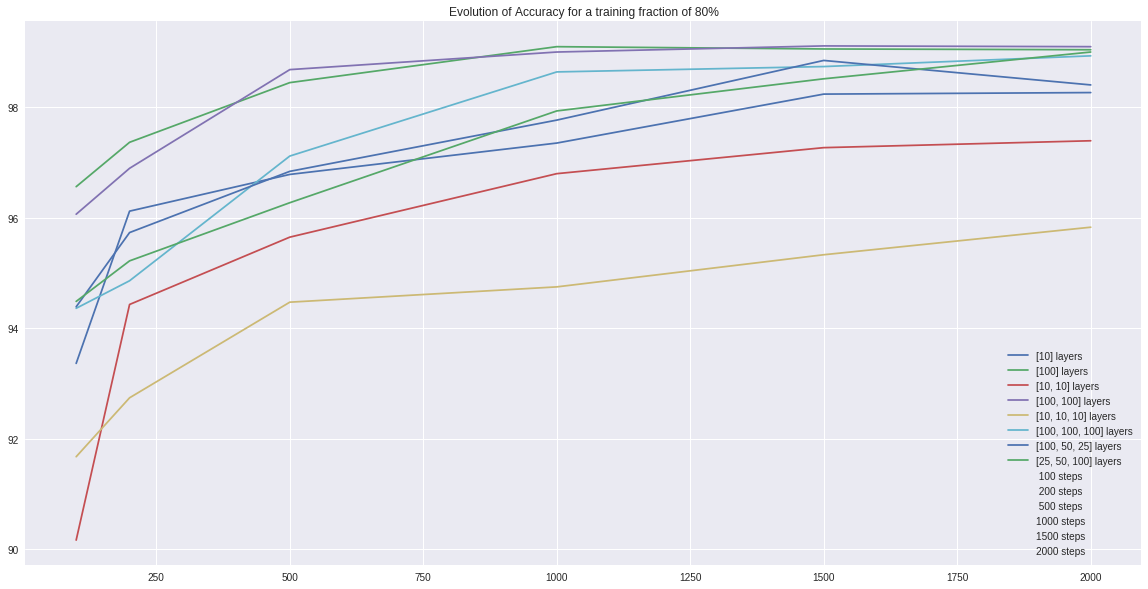

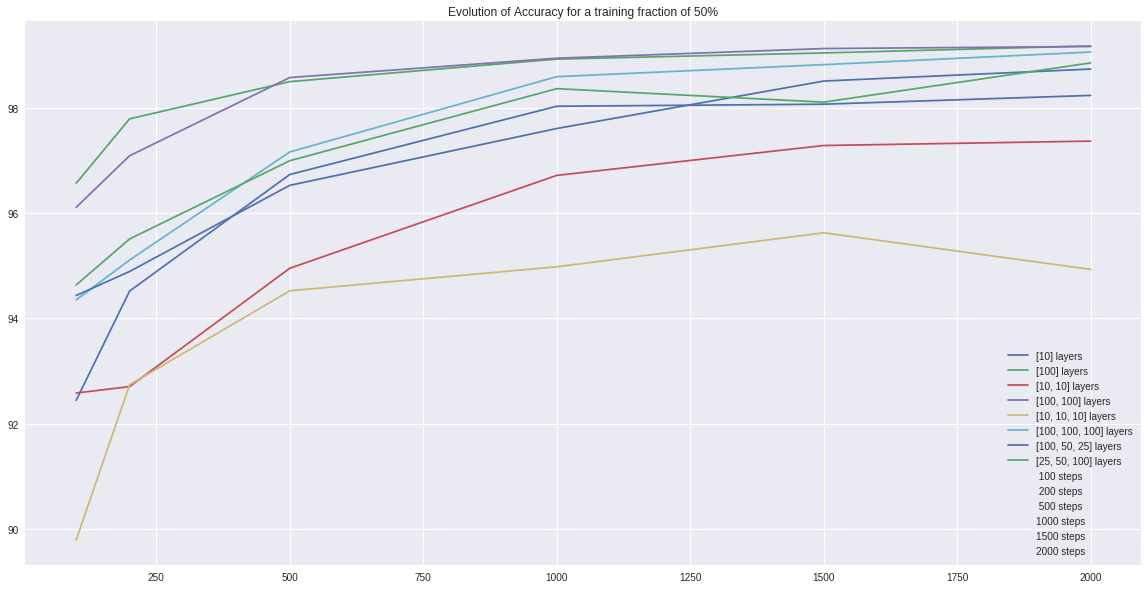

In [33]:
# k-fold Cross-validation data splitting results
display_model_results(kfcv_evaluations)

# Conclusion
The architectural choices of a **Neural Network** are of tremendous importance when designing such a network and its model, including the architecture, the way the data is split and fed into it, the number of times said data goes through the forward and backpropagation mechanisms. 

With our approach we have observed that, for instance, a **Neural Network** with a single layer comprised of 100 nodes, for our dataset, can better describe (without overfitting) the data then a network with two hidden layers of 10 neurons each.

## Other

### Deletes temporary files created by TensorFlow

In [0]:
# Allows deleting models save folder in windows
tf.summary.FileWriterCache.clear()

In [0]:
import tempfile
import os
from pathlib import Path
import shutil

temp_dir = Path(tempfile.gettempdir())
dir_list = [f for f in temp_dir.glob('tmp*') if f.is_dir()] 
for dir in dir_list:
    shutil.rmtree(dir, ignore_errors=True)
        